# Интернет магазин: Аналитика продаж и проверка гипотез

## Описание проекта

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).

## Цель проекта

Выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.  
  
1) Выполнить предобработку данных 
2) Провести исследовательский анализ данных  
3) Составить портрет пользователя для каждого региона  
4) Проверить гипотезы

## Предобработка данных

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', None)

In [76]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Есть пропуски в Name, Year_of_Release, Genre, Critic_Score, User_Score, Rating

In [4]:
data.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


В данных нет аномально больших и аномально маленьких значений с точки здравого смысла

Приведем названия колонок к нижнему регистру

In [78]:
data.columns = [x.lower() for x in data.columns]

Избавимся от пропусков из года выхода 

In [6]:
data['year_of_release'].value_counts().sort_index()

year_of_release
1980.0       9
1981.0      46
1982.0      36
1983.0      17
1984.0      14
1985.0      14
1986.0      21
1987.0      16
1988.0      15
1989.0      17
1990.0      16
1991.0      41
1992.0      43
1993.0      62
1994.0     121
1995.0     219
1996.0     263
1997.0     289
1998.0     379
1999.0     338
2000.0     350
2001.0     482
2002.0     829
2003.0     775
2004.0     762
2005.0     939
2006.0    1006
2007.0    1197
2008.0    1427
2009.0    1426
2010.0    1255
2011.0    1136
2012.0     653
2013.0     544
2014.0     581
2015.0     606
2016.0     502
Name: count, dtype: int64

In [7]:
data['year_of_release'].isna().sum()

269

In [8]:
data['year_of_release'].median()

2007.0

Заменим год выхода на медиану, это мне кажется более логичным, чем просто удалять эти строки или заполнять нулем. В данном случае медиана лучше среднего тем, что она будет целым числом. Пропуски могут быть вызваны ошибкой при сборе данных или отсутствием официальной информации.

In [9]:
data['year_of_release'].fillna(data['year_of_release'].median(), inplace=True)

In [10]:
data['user_score'].value_counts()

user_score
tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
1.1       2
1.9       2
9.6       2
0         1
9.7       1
Name: count, Length: 96, dtype: int64

In [11]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [12]:
data[data['user_score'] == 'tbd']['user_score'].count()

2424

In [13]:
data['user_score'].isna().sum()

6701

В данном случае tbd скорее всего означает, что недостаточно данных для оценки. Было предположение, что это обусловлено тем, что игра вышла недавно, проверим это:

In [14]:
data[data['user_score'] == 'tbd']['year_of_release'].value_counts().sort_index()

year_of_release
1997.0      1
1999.0      8
2000.0     43
2001.0     82
2002.0    192
2003.0     95
2004.0    107
2005.0    121
2006.0    124
2007.0    240
2008.0    326
2009.0    405
2010.0    331
2011.0    217
2012.0     24
2013.0     15
2014.0     21
2015.0     38
2016.0     34
Name: count, dtype: int64

Предположение оказалось ложным. Заменим и пропуски, и tbd на -1, чтобы в дальнейшем нам было легко их отсортировать в случае чего. Пропуски могут быть вызваны ошибкой при сборе данных или отсутствием официальной информации.

In [15]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = -1

In [16]:
data['user_score'].fillna('-1', inplace=True)

Теперь можем привести колонки к нужному типу данных, год релиза к целочисленному значению, оценку пользователей к числу с плавающей точкой

In [17]:
data = data.astype({'year_of_release': 'int', 'user_score': 'float'})

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16715 non-null  int32  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       16715 non-null  float64
 10  rating           9949 non-null   object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.3+ MB


Есть два пропуска в столбце name, просто удалим эти строки полностью 

In [19]:
data.dropna(subset=['name'], inplace=True)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  int32  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       16713 non-null  float64
 10  rating           9949 non-null   object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.5+ MB


Отлично, они совпали с пропусками в жанрах

In [21]:
data['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23.,
       24., 21., 17., 22., 13.])

In [22]:
data.sample(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
10747,Cubic Ninja,3DS,2011,Platform,0.05,0.04,0.00,0.01,51.0,5.9,E
9227,Master Jin Jin's IQ Challenge,DS,2006,Misc,0.13,0.00,0.00,0.01,38.0,-1.0,E
11115,Atelier Totori: The Adventurer of Arland,PSV,2012,Role-Playing,0.00,0.00,0.09,0.00,NaN,-1.0,NaN
6587,Teen Titans,PS2,2006,Action,0.12,0.10,0.00,0.03,56.0,8.6,E10+
10515,Ride,XOne,2015,Racing,0.04,0.05,0.00,0.01,54.0,5.3,E


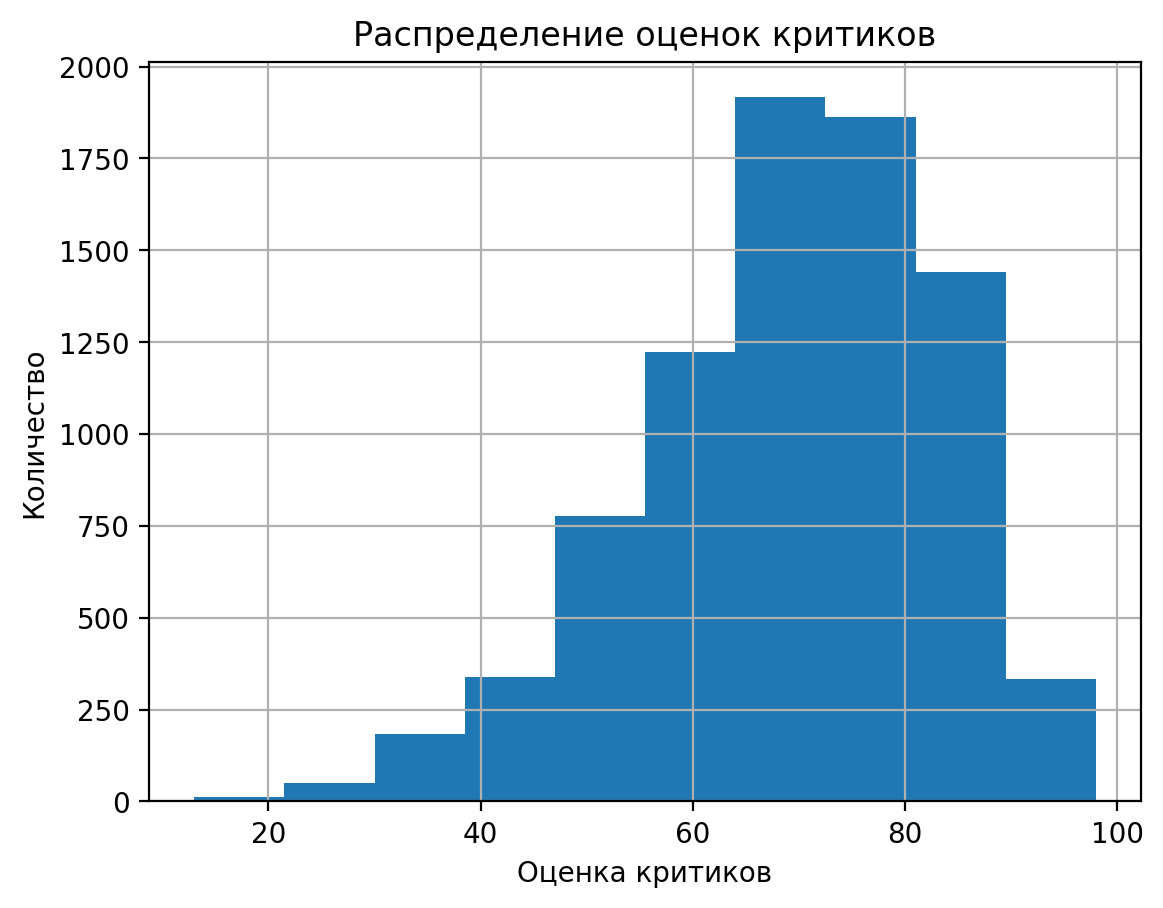

In [23]:
data['critic_score'].hist()
plt.xlabel('Оценка критиков')
plt.ylabel('Количество')
plt.title('Распределение оценок критиков')
plt.show()

Здесь аналогично заменим пропуски на -1 для удобной фильтрации в дальнейшем. Пропуски могут быть вызваны ошибкой при сборе данных или отсутствием официальной информации.

In [24]:
data['critic_score'].fillna(-1, inplace=True)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  int32  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     16713 non-null  float64
 9   user_score       16713 non-null  float64
 10  rating           9949 non-null   object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.5+ MB


In [26]:
data['rating'].isna().sum()

6764

In [27]:
data['rating'].value_counts()

rating
E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: count, dtype: int64

In [28]:
data[data['rating'].isna()]['genre'].value_counts()

genre
Action          1181
Misc             868
Adventure        857
Sports           839
Role-Playing     721
Fighting         411
Racing           377
Strategy         344
Platform         319
Simulation       305
Shooter          304
Puzzle           238
Name: count, dtype: int64

Проверил, есть ли связь между отсутствием рейтинга и жанром

In [84]:
pd.Series(data[data['rating'].isna()]['name'].unique()).sample(5, random_state=123)

474                 Disney's Chip 'n Dale: Rescue Rangers
1633                                      Guardian Heroes
5371                         L.G.S: Shinsetsu Houshinengi
5362    TV Anime Idolm@ster: Cinderella Girls G4U! Pac...
5075       Otome wa Oanesama Boku ni Koi Shiteru Portable
dtype: object

Рандомно выбрал из списка 5 игр и проверил вручную, оказалось, что есть игры как 3+ , так и 17+ , меняем на unknown. Пропуски скорее всего обусловлены отсутствием официальной информации.

In [30]:
data['rating'].fillna('unknown', inplace=True)

In [31]:
data['rating'].unique()

array(['E', 'unknown', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

Из статьи на вики узнал, что K-A и E - это одно и то же (0+), K-A - устаревшее название, заменим его на E

In [32]:
data.loc[data['rating'] == 'K-A', 'rating'] = 'E'
data.loc[data['rating'] == 'AO', 'rating'] = 'M'
data.loc[data['rating'] == 'RP', 'rating'] = 'unknown'
data.loc[data['rating'] == 'EC', 'rating'] = 'E'

Проверим 'name' на дубликаты

In [33]:
data['name'].duplicated().sum()

5154

Очевидно, что многие игры были выпущены для разных платформ, поэтому и много дубликатов. Проверим более узкие дубликаты

In [34]:
data[data.duplicated(['name', 'platform', 'year_of_release'])]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16230,Madden NFL 13,PS3,2012,Sports,0.0,0.01,0.0,0.0,83.0,5.5,E


Есть одна строчка, удалим ее

In [35]:
data.drop_duplicates(subset=['name', 'platform', 'year_of_release'], inplace=True)
data.reset_index(drop=True)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,unknown
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,unknown
...,...,...,...,...,...,...,...,...,...,...,...
16707,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,-1.0,-1.0,unknown
16708,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,-1.0,-1.0,unknown
16709,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,-1.0,-1.0,unknown
16710,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,-1.0,-1.0,unknown


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16712 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16712 non-null  object 
 1   platform         16712 non-null  object 
 2   year_of_release  16712 non-null  int32  
 3   genre            16712 non-null  object 
 4   na_sales         16712 non-null  float64
 5   eu_sales         16712 non-null  float64
 6   jp_sales         16712 non-null  float64
 7   other_sales      16712 non-null  float64
 8   critic_score     16712 non-null  float64
 9   user_score       16712 non-null  float64
 10  rating           16712 non-null  object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.5+ MB


Добавим в датасет столбец 'total_sales' с суммарными продажами во всех регионах. Он понадобится в дальнейшем.

In [37]:
data['total_sales'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

### Выводы по разделу 

1) Избавились от всех пропусков, в одном случае заменили на медиану, в других - заменили на -1, чтобы в дальнейшем при необходимости легко их  идентифицировать 
2) Типы данных всех колонок приведены к нужному формату
3) Удален один неявный дубликат, произведено объединение категорий рейтинга 'K-A' и 'E'
4) Добавлен столбец total_sales с суммарными продажами каждой игры
5) Данные по всем столбцам выглядят нормально, без явных аномалий

## Исследовательский анализ данных

In [38]:
data['year_of_release'].value_counts().sort_index()

year_of_release
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1466
2008    1427
2009    1426
2010    1255
2011    1136
2012     652
2013     544
2014     581
2015     606
2016     502
Name: count, dtype: int64

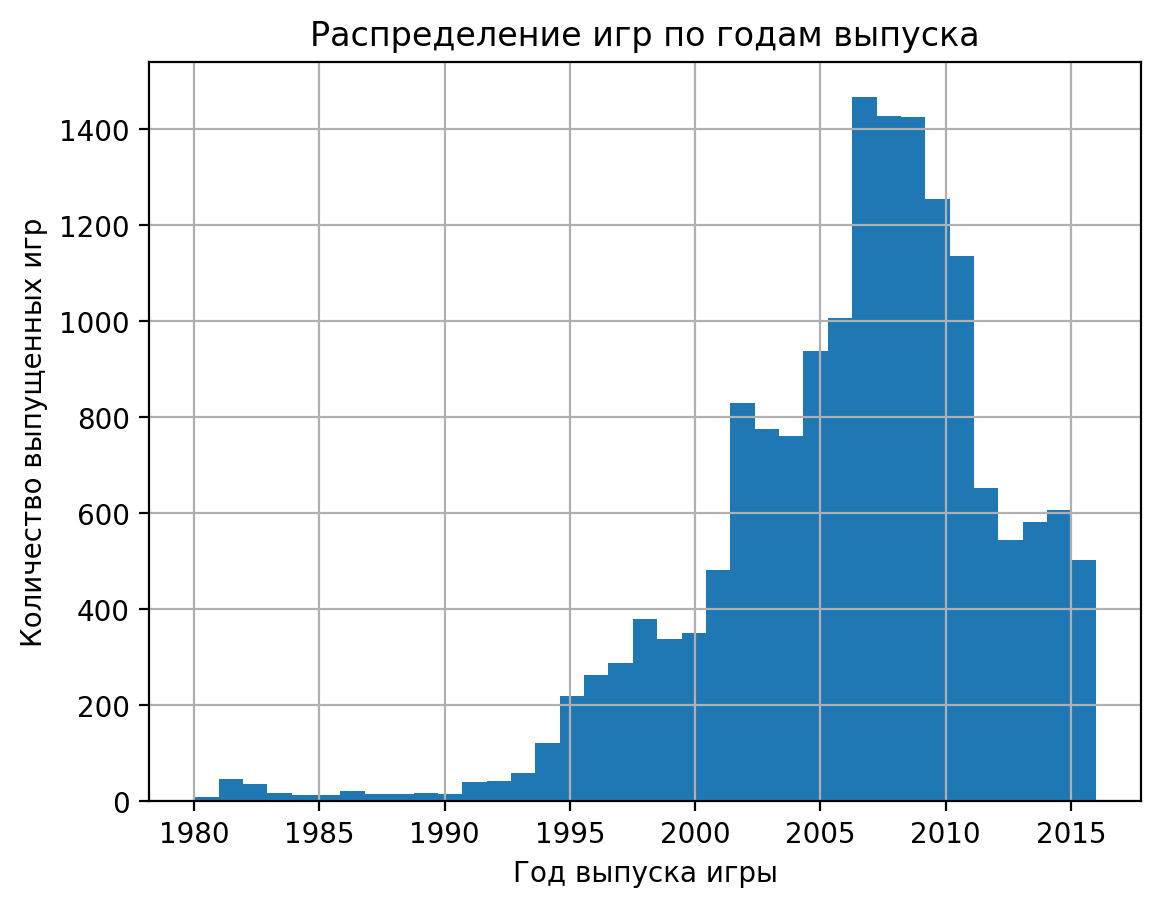

In [39]:
data['year_of_release'].hist(bins=data['year_of_release'].nunique())
plt.xlabel('Год выпуска игры')
plt.ylabel('Количество выпущенных игр')
plt.title('Распределение игр по годам выпуска')
plt.show()

Игры начали активно выходить с 94-95 года, пик пришелся на 2006-2011е года. Визуально сразу можно сказать, что данные до 95 года нам не понадобятся. Смотрим дальше

Выберем топ 10 платформ по продажам и создадим новый датасет с фильтрацией по индексам top_platforms

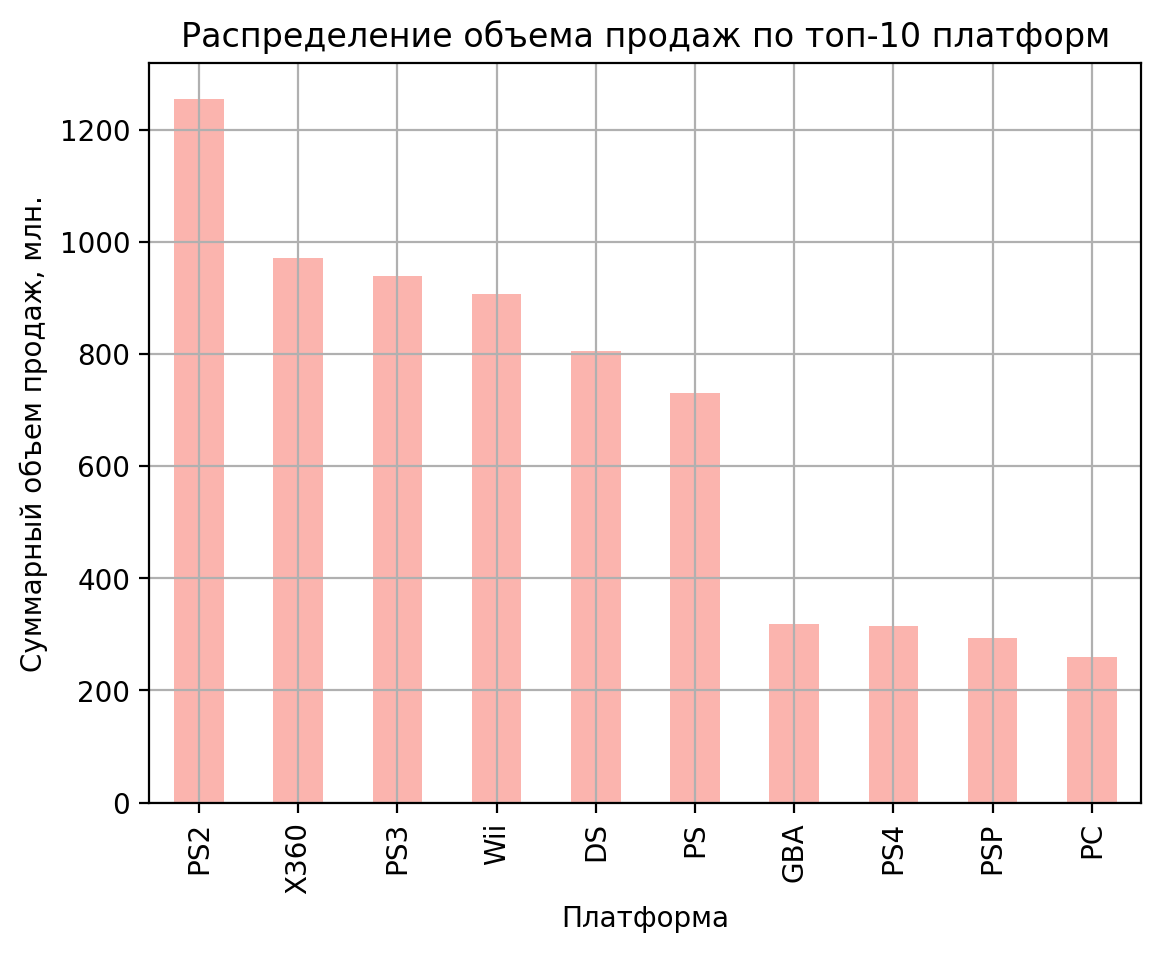

In [40]:
top_platforms = data.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(10)
data_top_platforms = data[data['platform'].isin(top_platforms.index)]
top_platforms.plot(kind='bar', grid=True, cmap='Pastel1')
plt.xlabel('Платформа')
plt.ylabel('Суммарный объем продаж, млн.')
plt.title('Распределение объема продаж по топ-10 платформ')
plt.show()

Создадим сводную таблицу с годами в качестве индекса, платформами в качестве колонок, а значениями будут общие суммарные продажи для каждой платформы и года. Потом построим стековую диаграмму

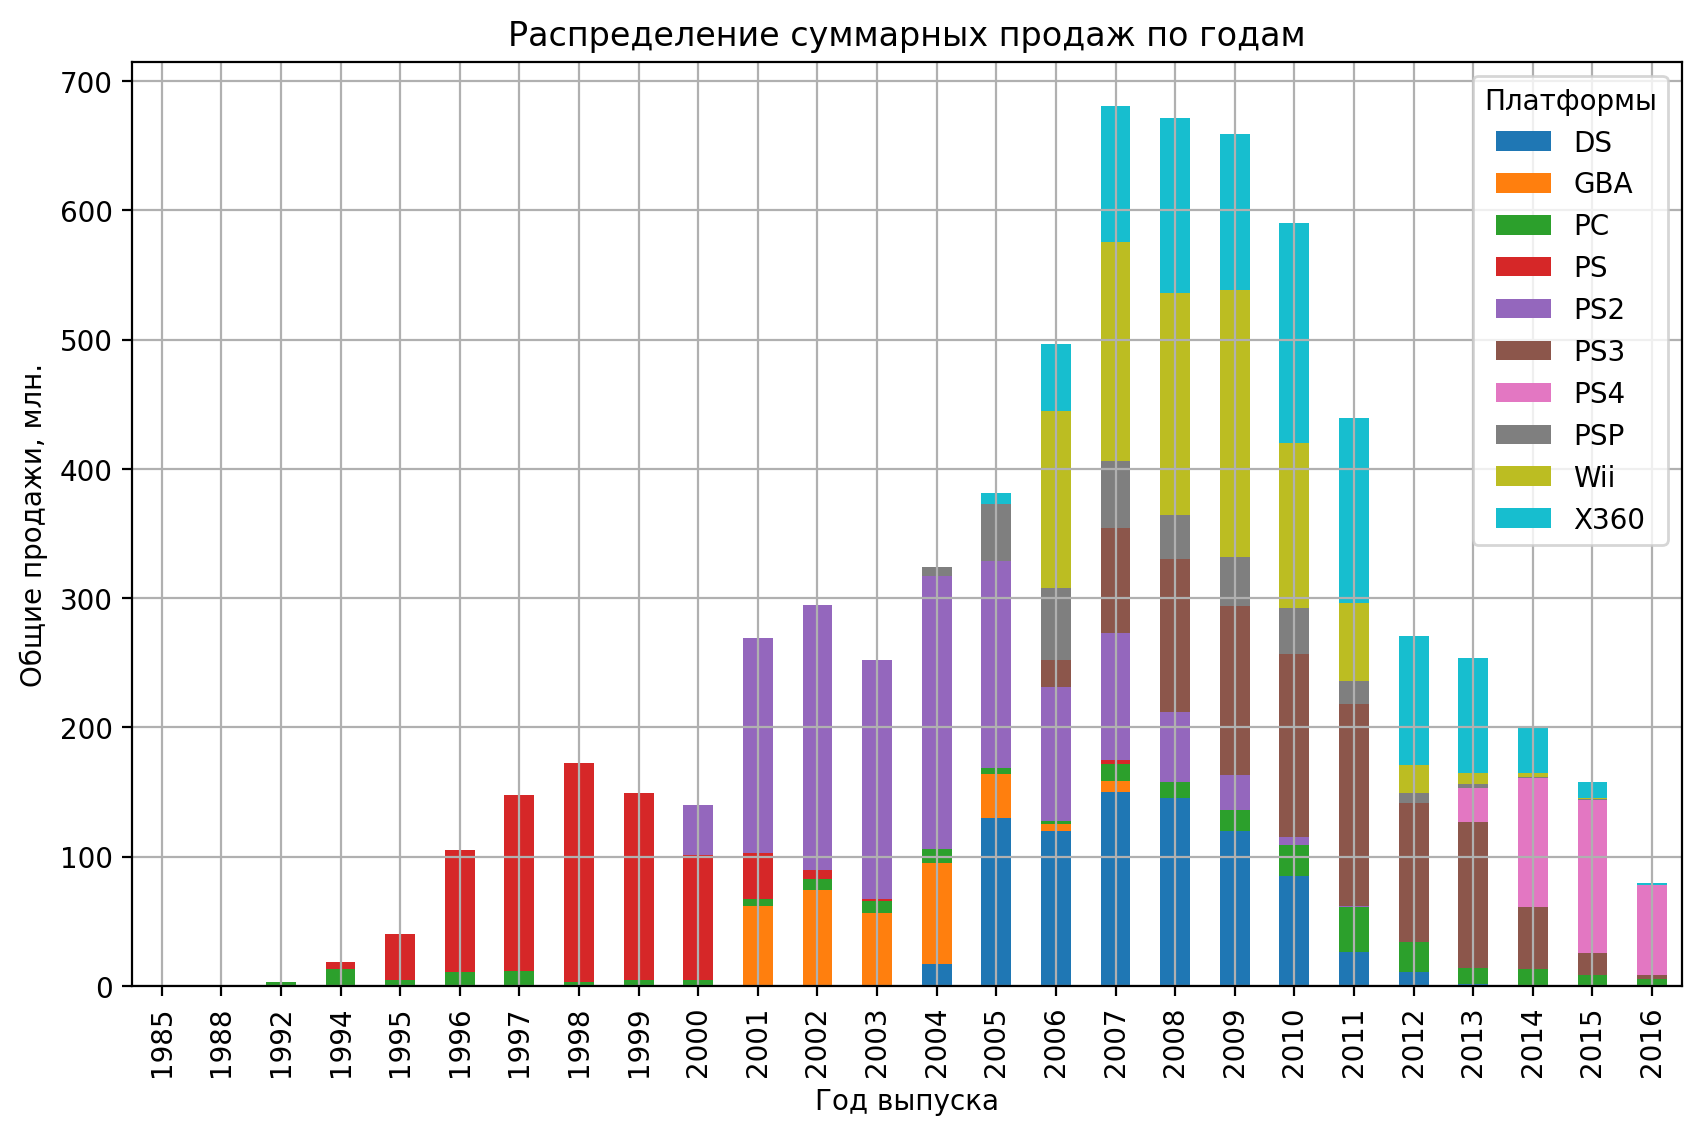

In [41]:
pivot_platforms = data_top_platforms.pivot_table(index='year_of_release', columns='platform', 
                                                 values='total_sales', aggfunc='sum')

pivot_platforms.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.xlabel('Год выпуска')
plt.ylabel('Общие продажи, млн.')
plt.title('Распределение суммарных продаж по годам')

plt.legend(title='Платформы')
plt.grid(True)
plt.show()

По графику заметно, что срок жизни платформы 6-10 лет, рост зачастую колокообразный, с подъемом, пиком и спадом. Из общей картины сильно выделяется PC (персональный компьютер), игры для которого хоть и имеют сравнительно небольшой объем продаж, однако выходят в том или ином заметном объеме стабильно начиная с 1992 года. Еще мы видим сплеск продаж в 06-11гг, поэтому возьмем данные начиная с 2012 года

In [42]:
actual_data = data[data['year_of_release'] >= 2012]

В данном случае удобнее будет делать выводы по линейной диаграмме

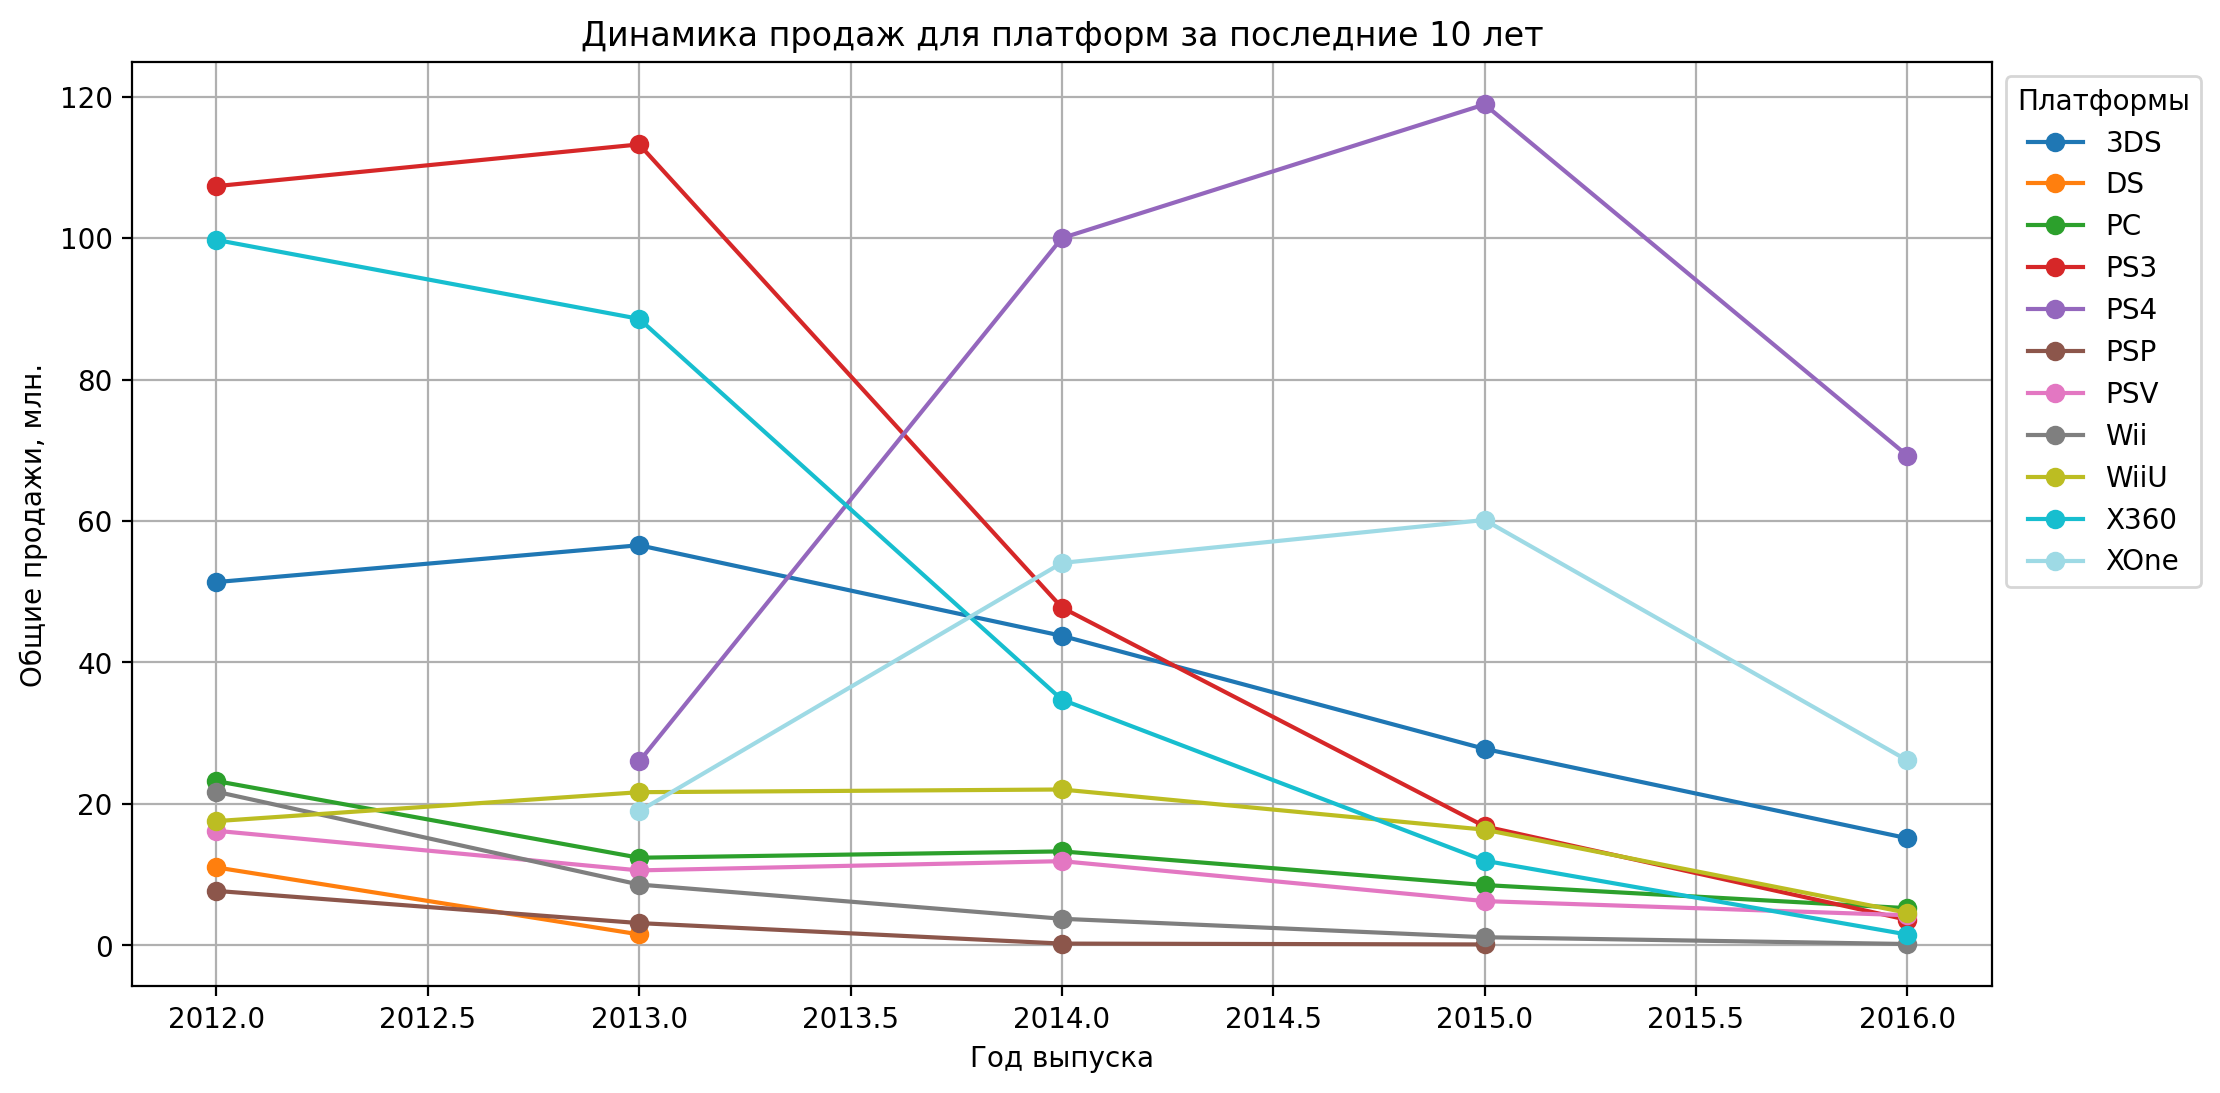

In [43]:
pivot_platforms_actual = actual_data.pivot_table(index='year_of_release', columns='platform', 
                                                 values='total_sales', aggfunc='sum')

pivot_platforms_actual.plot(kind='line', figsize=(12, 6), marker='o', cmap='tab20')

plt.xlabel('Год выпуска')
plt.ylabel('Общие продажи, млн.')
plt.title('Динамика продаж для платформ за последние 10 лет')


plt.legend(title='Платформы', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

In [44]:
pivot_platforms_actual

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2012,51.36,11.01,23.22,107.35,NaN,7.69,16.19,21.71,17.56,99.74,NaN
2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,NaN,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,NaN,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,NaN,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


На момент выгрузки датасета по продажам лидируют PS4 и XOne, обе появились только в 2013 году, т.е. у них есть все шансы пройти все стандартные стадии цикла и взорвать рынок в будущем.  

Еще есть портативные консоли, но их доля в общем объеме продаж не так значительна. Примерно на одном уровне с ними идет PC, как уже писалось ранее, PC - отдельная категория, которая скорее всего надолго сохранит свою стабильно небольшую долю рынка.  

Популярность X360 и PS3 в последние годы падает.  

In [45]:
actual_data.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

platform
PS4     314.14
PS3     288.78
X360    236.54
3DS     194.61
XOne    159.32
WiiU     82.19
PC       62.65
PSV      49.18
Wii      35.37
DS       12.55
PSP      11.19
Name: total_sales, dtype: float64

Построим боксплоты по глобальным продажам в разбивке по платформам

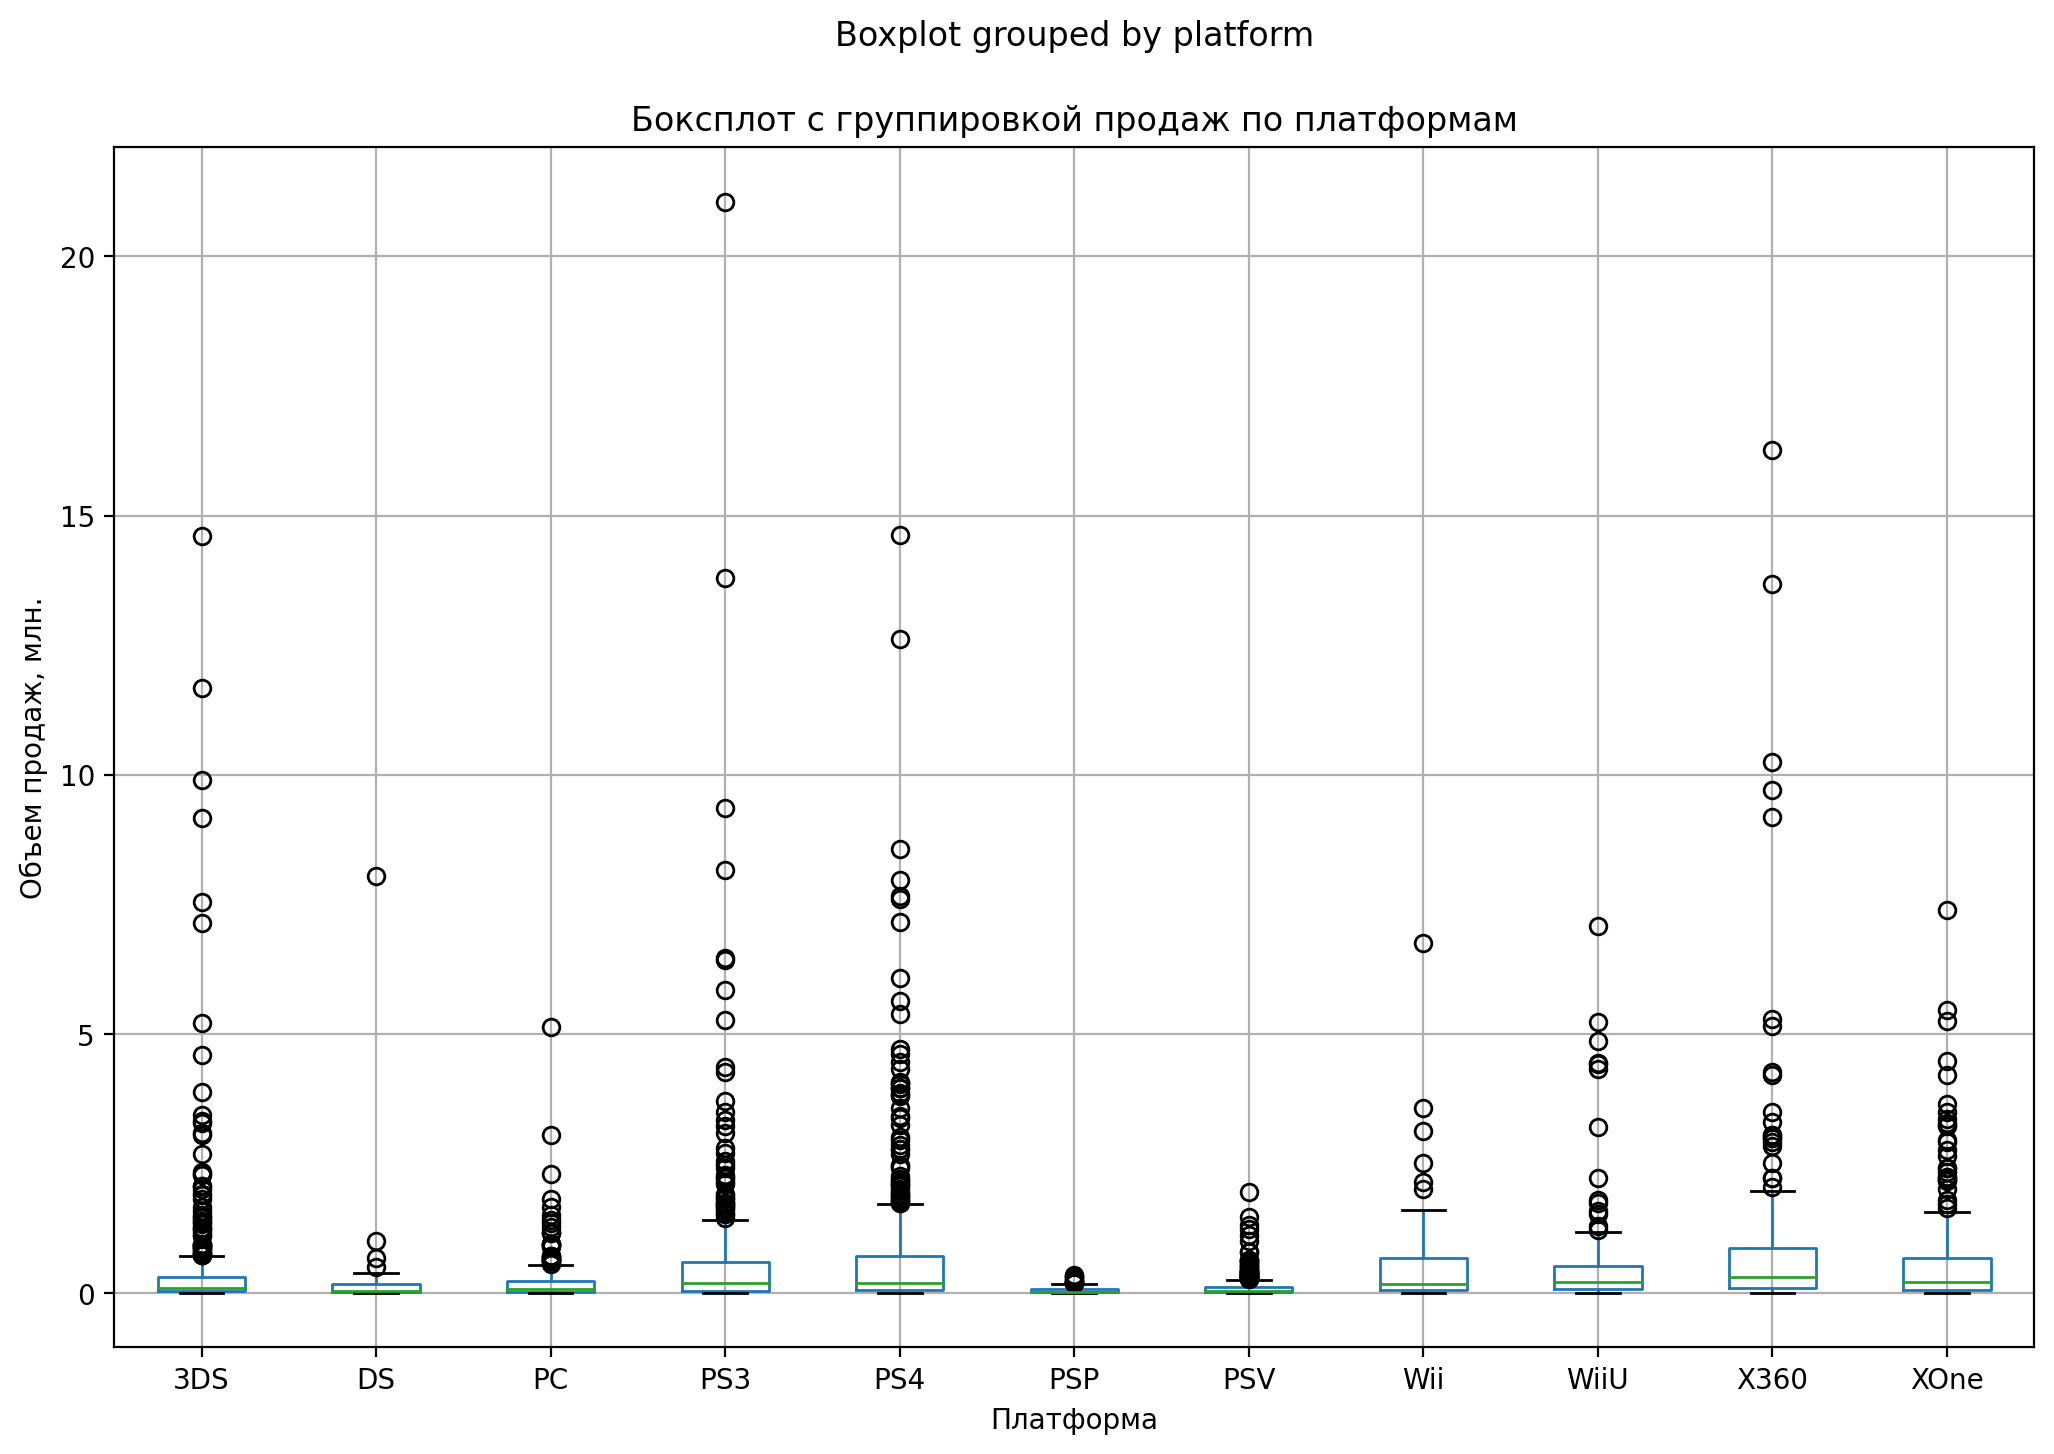

In [46]:
actual_data.boxplot(column='total_sales', by='platform', figsize=(12, 8))
plt.title('Боксплот с группировкой продаж по платформам')
plt.xlabel('Платформа')
plt.ylabel('Объем продаж, млн.')
plt.show()

Ничего не понятно, очень сильно мешают аномально большие значения, уберем их с помощью параметра showfliers

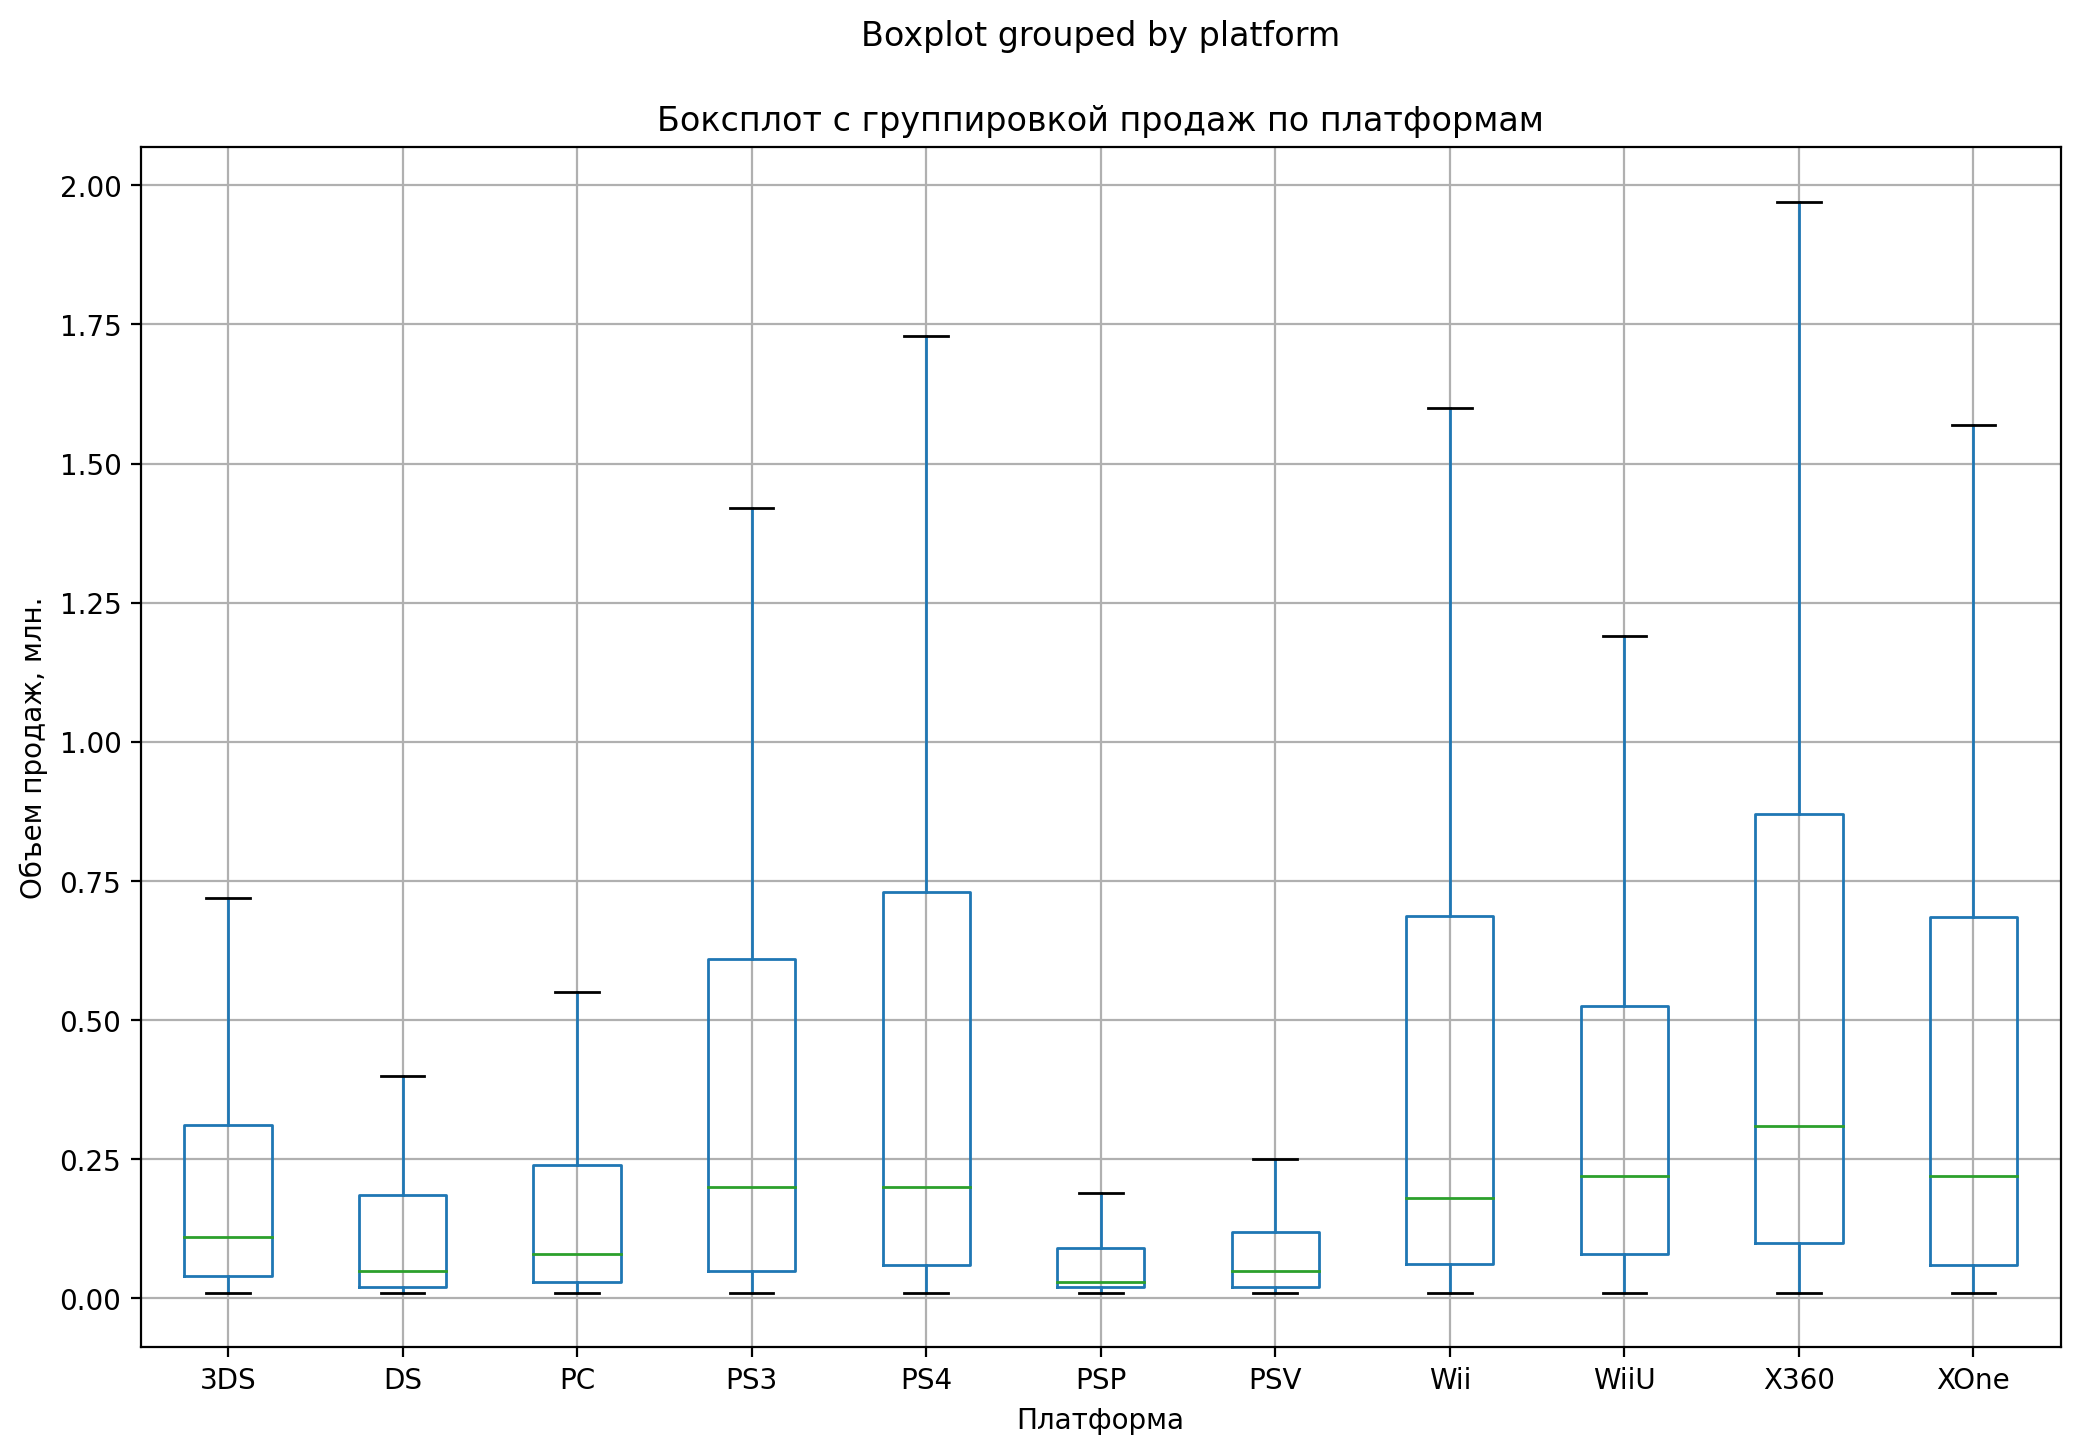

In [47]:
actual_data.boxplot(column='total_sales', by='platform', figsize=(12, 8), showfliers=False)
plt.title('Боксплот с группировкой продаж по платформам')
plt.xlabel('Платформа')
plt.ylabel('Объем продаж, млн.')
plt.show()

Распределение общих продаж варьируется от платформы к платформе. Некоторые платформы, такие как PS4 и XOne, имеют более высокие медианы и более широкий размах продаж по сравнению с более старыми платформами, например 2600 и N64  
  
Новейшие платформы, такие как PS4, X360, Wii, демонстрируют большой размах и более высокие медианные значения продаж, что указывает на более широкий диапазон продаж с некоторыми очень успешными тайтлами  
  
Для всех платформ кроме X360 платформ медианные значения продаж находятся на низком уровне (ниже 0.25), что говорит о том, что большинство игр имеют скромные объемы продаж, а очень высокие продажи это скорее исключение  

Возьмем одну из самых популярных платформу X360, чтобы проверить, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.

Смотрим оценки пользователей

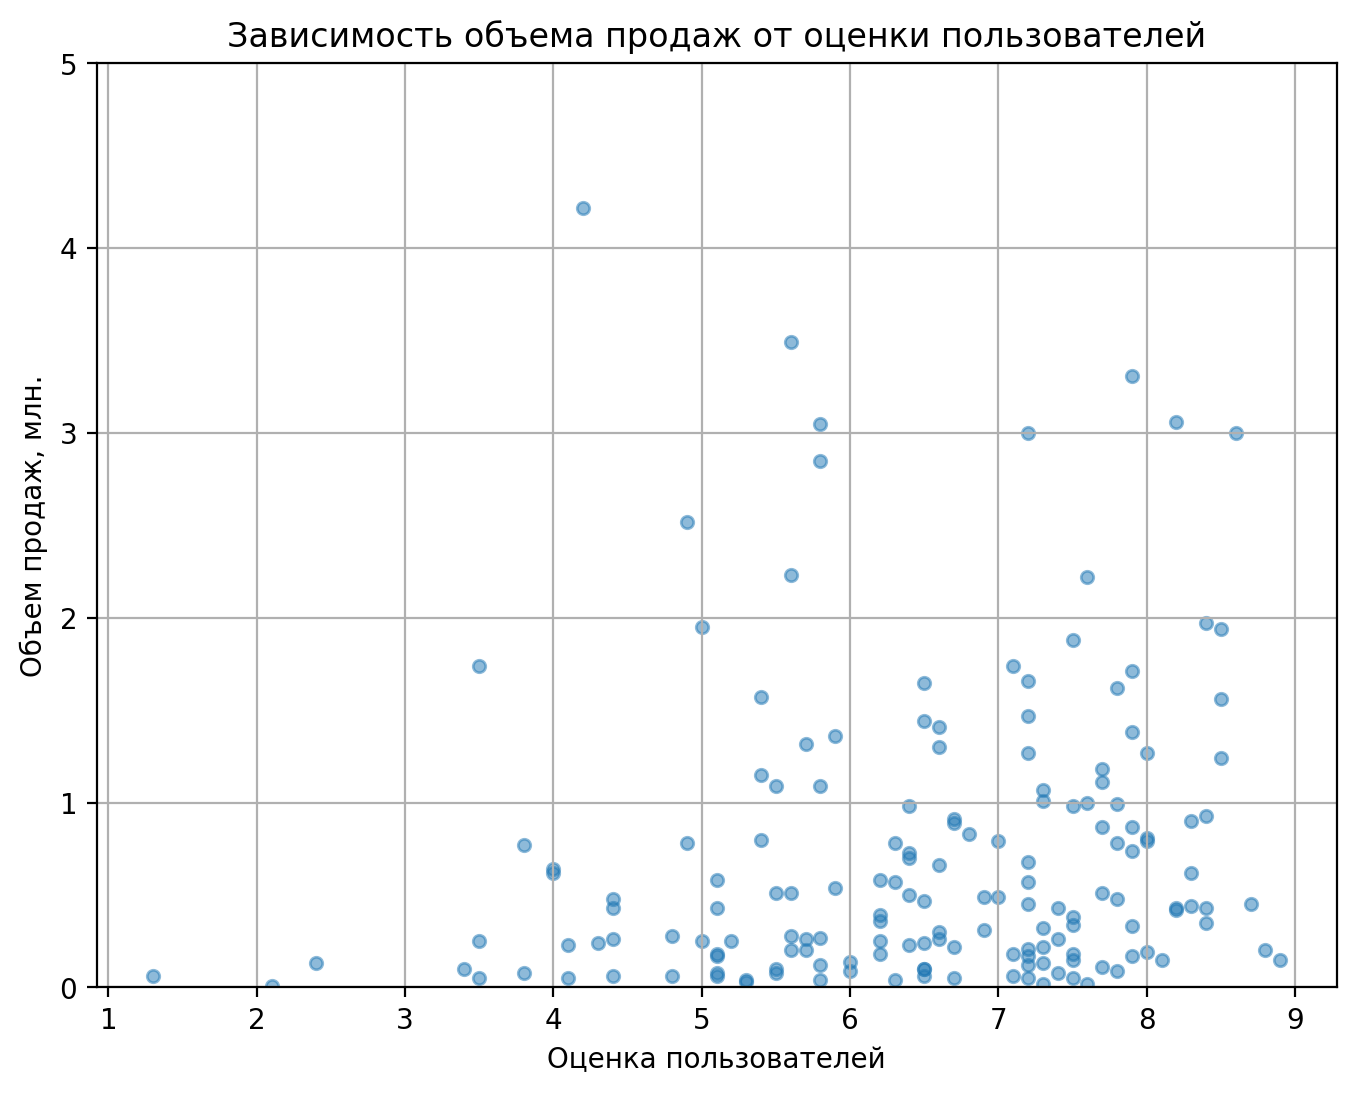

In [48]:
test_data = actual_data[actual_data['platform'] == 'X360']

#избавимся от nan 
test_data = test_data[(test_data['user_score'] != -1) & (test_data['critic_score'] != -1)]
test_data.plot(x='user_score', y='total_sales', kind='scatter', 
                                                    figsize=(8, 6), sharex=False, grid=True, alpha=0.5)

plt.ylim(0, 5)
plt.title('Зависимость объема продаж от оценки пользователей')
plt.xlabel('Оценка пользователей')
plt.ylabel('Объем продаж, млн.')
plt.show()


In [49]:
test_data['user_score'].corr(test_data['total_sales'])

-0.0020140394826897853

Нет ни прямой, ни обратной связи между оценкой пользователей и объемом продаж. 

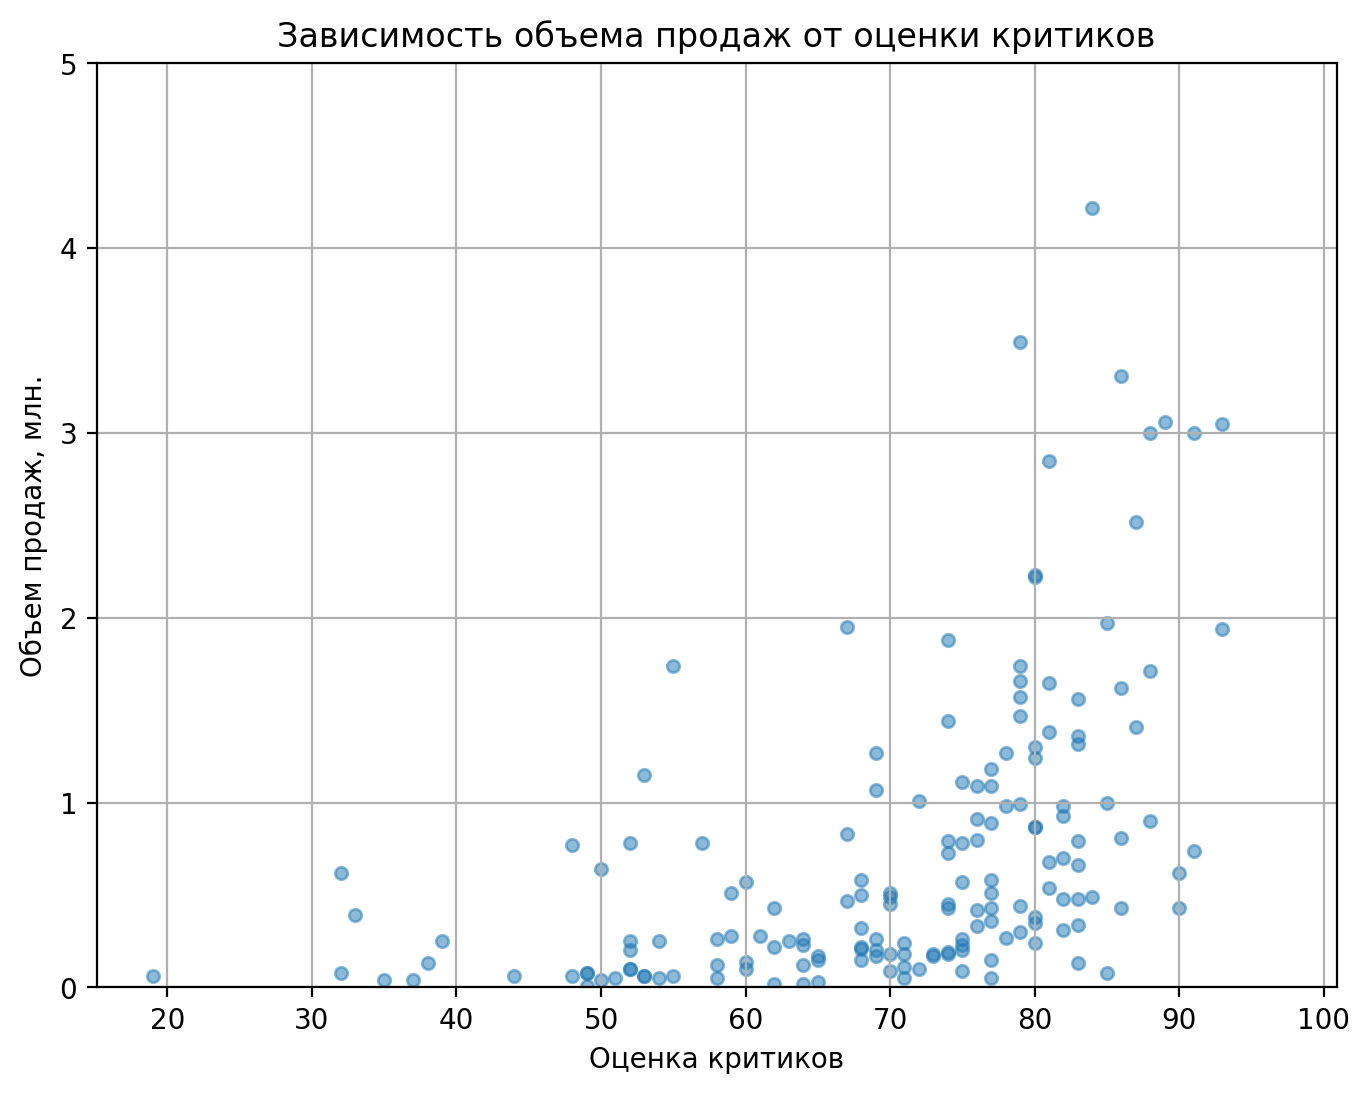

In [50]:
test_data.plot(x='critic_score', y='total_sales', kind='scatter',
                                                    figsize=(8, 6), sharex=False, grid=True, alpha=0.5)

plt.ylim(0, 5)
plt.title('Зависимость объема продаж от оценки критиков')
plt.xlabel('Оценка критиков')
plt.ylabel('Объем продаж, млн.')
plt.show()

In [51]:
test_data['critic_score'].corr(test_data['total_sales'])

0.3605734888507336

Существует слабая связь между оценкой критиков и объемом продаж игры. Однако этот фактор не является решающим, т.к. коэффициент корреляции достаточно небольшой

Чтобы убедиться в верности наших выводов, проведем аналогичный тест на коэфф. корреляции Пирсона с другой популярной платформой, которая к тому же является конкурентом предыдущей

In [52]:
test_data1 = actual_data[actual_data['platform'] == 'PS4']
test_data1 = test_data1[(test_data1['user_score'] != -1) & (test_data1['critic_score'] != -1)] 
print(test_data1['user_score'].corr(test_data1['total_sales']), test_data1['critic_score'].corr(test_data1['total_sales']))

-0.03362497596528878 0.40589480145836687


Коэффициенты корреляции между объемом продаж и оценками пользователей/критиков примерно такие же, как и в предыдущем тесте

Проведем еще 3 теста для PS3, 3DS и XOne

In [53]:
test_data2 = actual_data[actual_data['platform'] == 'PS3']
test_data2 = test_data2[(test_data2['user_score'] != -1) & (test_data2['critic_score'] != -1)] 
print('PS3 corr:', test_data2['user_score'].corr(test_data2['total_sales']), test_data2['critic_score'].corr(test_data2['total_sales']))

PS3 corr: 0.001425095594866698 0.33372581120725897


In [54]:
test_data3 = actual_data[actual_data['platform'] == '3DS']
test_data3 = test_data3[(test_data3['user_score'] != -1) & (test_data3['critic_score'] != -1)] 
print('3DS corr:', test_data3['user_score'].corr(test_data3['total_sales']), test_data3['critic_score'].corr(test_data3['total_sales']))

3DS corr: 0.20181255007655283 0.31055301915326294


In [55]:
test_data4 = actual_data[actual_data['platform'] == 'XOne']
test_data4 = test_data4[(test_data4['user_score'] != -1) & (test_data4['critic_score'] != -1)] 
print('XOne corr:', test_data4['user_score'].corr(test_data4['total_sales']), test_data4['critic_score'].corr(test_data4['total_sales']))

XOne corr: -0.09400318326920852 0.41042203561296375


Коэффициенты корреляции между объемом продаж и оценками пользователей/критиков во всех случаях примерно равны, т.е. **нет связи между оценкой пользователей и продажами** (только в 1 случае была очень слабая связь), и во всех 5 случаях **есть слабая прямая связь между оценкой критиков и продажами**

Посмотрим распределение среднего объема продаж игр по жанрам

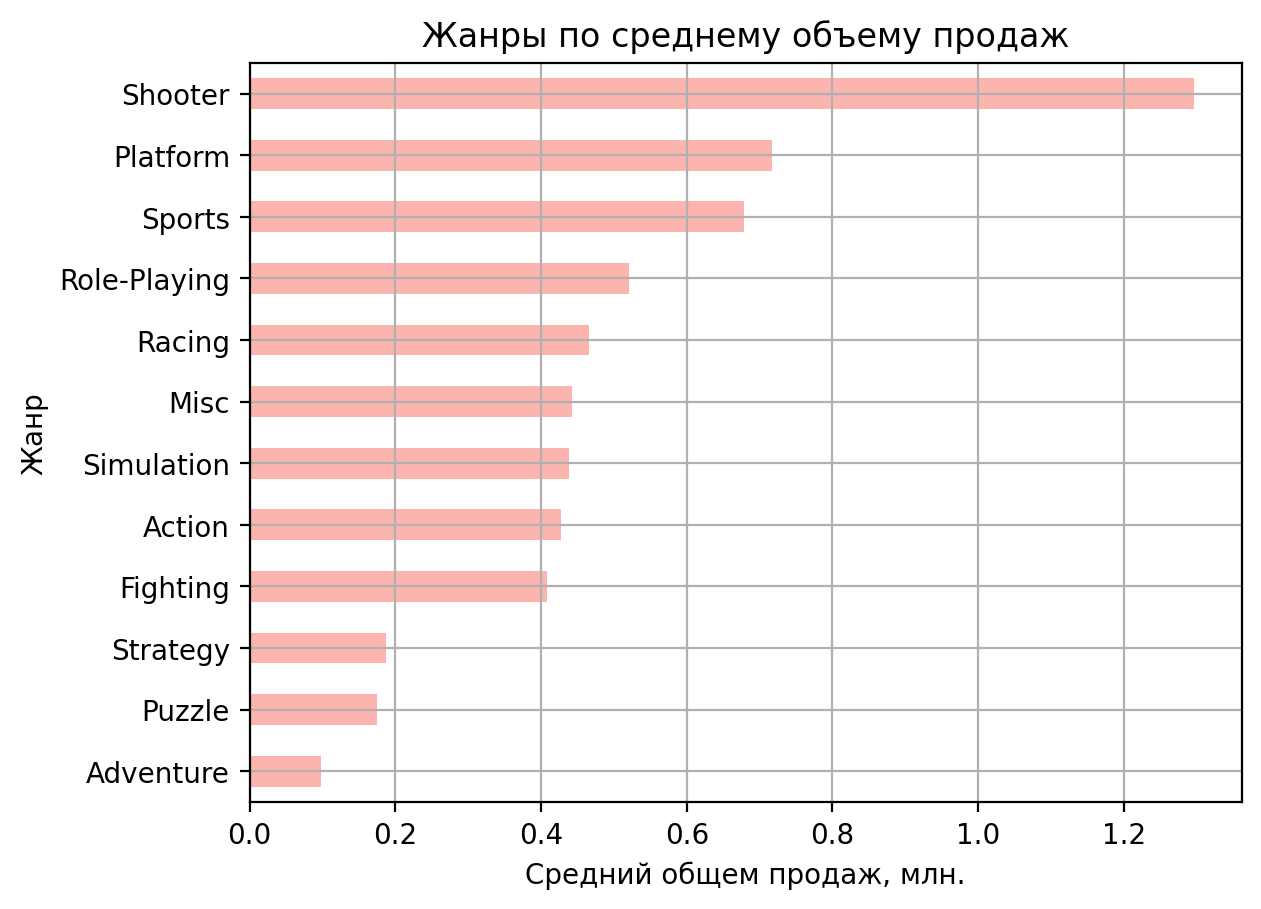

In [56]:
actual_data.groupby('genre')['total_sales'].mean().sort_values().plot(kind='barh', grid=True, cmap='Pastel1')
plt.xlabel('Средний общем продаж, млн.')
plt.ylabel('Жанр')
plt.title('Жанры по среднему объему продаж')
plt.show()

Популярность жанров сильно разнится, самые популярные - Shooter, Platform и Sports, наименее популярные - Strategy, Puzzle и Adventure

1) Игры начали активно выходить с **94-95 года**, есть пик на **2006-2011е годах.**  
2) Срок жизни платформы **6-10 лет**, рост зачастую колокообразный, с подъемом, пиком и спадом. Сильно выделяется PC, игры для которого хоть и имеют сравнительно небольшой объем продаж, однако выходят в том или ином заметном объеме стабильно начиная с 1992 года.  
3) Смотрим данные за последние **5-6 лет**, которые кажутся приближенным к **минимальному сроком жизни платформы** и не включают в себя пик 06-11х годов, т.е. начиная с **2012 г**  
4) По продажам **лидируют PS4 и XOne**. Еще есть различные **портативные консоли**, но их доля в общем объеме продаж **не так значительна**. Примерно на одном уровне с ними идет **PC**, отдельная категория, которая скорее всего **надолго сохранит свою стабильно небольшую долю рынка.**  
5) Популярность **X360 и PS3 в последние годы падает.**  
6) Новейшие платформы, такие как **PS4, XOne и WiiU,** демонстрируют большой размах и более высокие медианные значения продаж, что указывает на **более широкий диапазон продаж с некоторыми очень успешными тайтлами**  
7) **Для всех платформ кроме X360** медианные значения продаж находятся на низком уровне (ниже 0.25), что говорит о том, что **большинство игр имеют скромные объемы продаж, а очень высокие продажи это скорее исключение**  
8) Между **оценкой пользователей и объемом продаж** **нет** или почти нет **связи.** Есть **слабая связь между оценкой критиков и объемом продаж.**  
9) Успешность жанров сильно разнится, **самые успешные по объему продаж - Shooter, Platform и Sports,** **наименее успешные - Strategy, Puzzle и Adventure**  

## Портрет пользователя каждого региона

In [57]:
actual_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1.0,-1.0,unknown,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,-1.0,-1.0,unknown,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79


Для начала посмотрим, как распределены продажи по всем регионам

<Axes: >

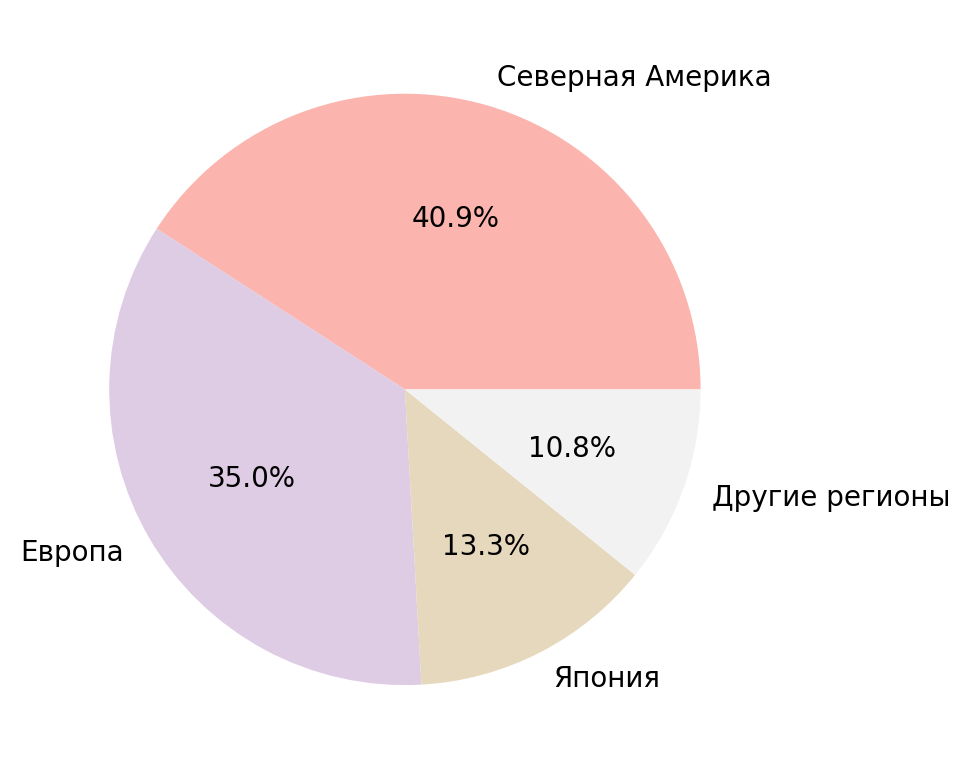

In [58]:
allreg = pd.Series([actual_data['na_sales'].sum(), actual_data['eu_sales'].sum(), 
                   actual_data['jp_sales'].sum(), actual_data['other_sales'].sum()])

allreg.index = ['Северная Америка', 'Европа', 'Япония', 'Другие регионы']

allreg.plot(kind='pie', autopct='%1.1f%%', cmap='Pastel1')

40% всех продаж в Северной Америке, около 35% в Европе, в Японии 13%, в других регионах около 10%

Посмотрим топ 5 самых популярных платформ по Европе, Северной Америке, Европе и остальным регионам

Сгруппируем все 4 группы региона по платформам и посчитаем суммарные продажи, возьмем 5 топовых для каждого региона и посчитаем Other (продажи по остальным платформам)

In [59]:
na_data_sales = actual_data.groupby('platform')['na_sales'].sum().sort_values(ascending=False)
na_sales_plot = na_data_sales.head(5)
na_sales_plot['Other'] = na_data_sales[5:].sum()

eu_data_sales = actual_data.groupby('platform')['eu_sales'].sum().sort_values(ascending=False)
eu_data_plot = eu_data_sales.head(5)
eu_data_plot['Other'] = eu_data_sales[5:].sum()

jp_data_sales = actual_data.groupby('platform')['jp_sales'].sum().sort_values(ascending=False)
jp_data_plot = jp_data_sales.head(5)
jp_data_plot['Other'] = jp_data_sales[5:].sum()

other_data_sales = actual_data.groupby('platform')['other_sales'].sum().sort_values(ascending=False)
other_data_plot = other_data_sales.head(5)
other_data_plot['Other'] = other_data_sales[5:].sum()

Создадим поддиаграммы в виде матрицы 2 на 2, чтобы удобнее было сравнивать

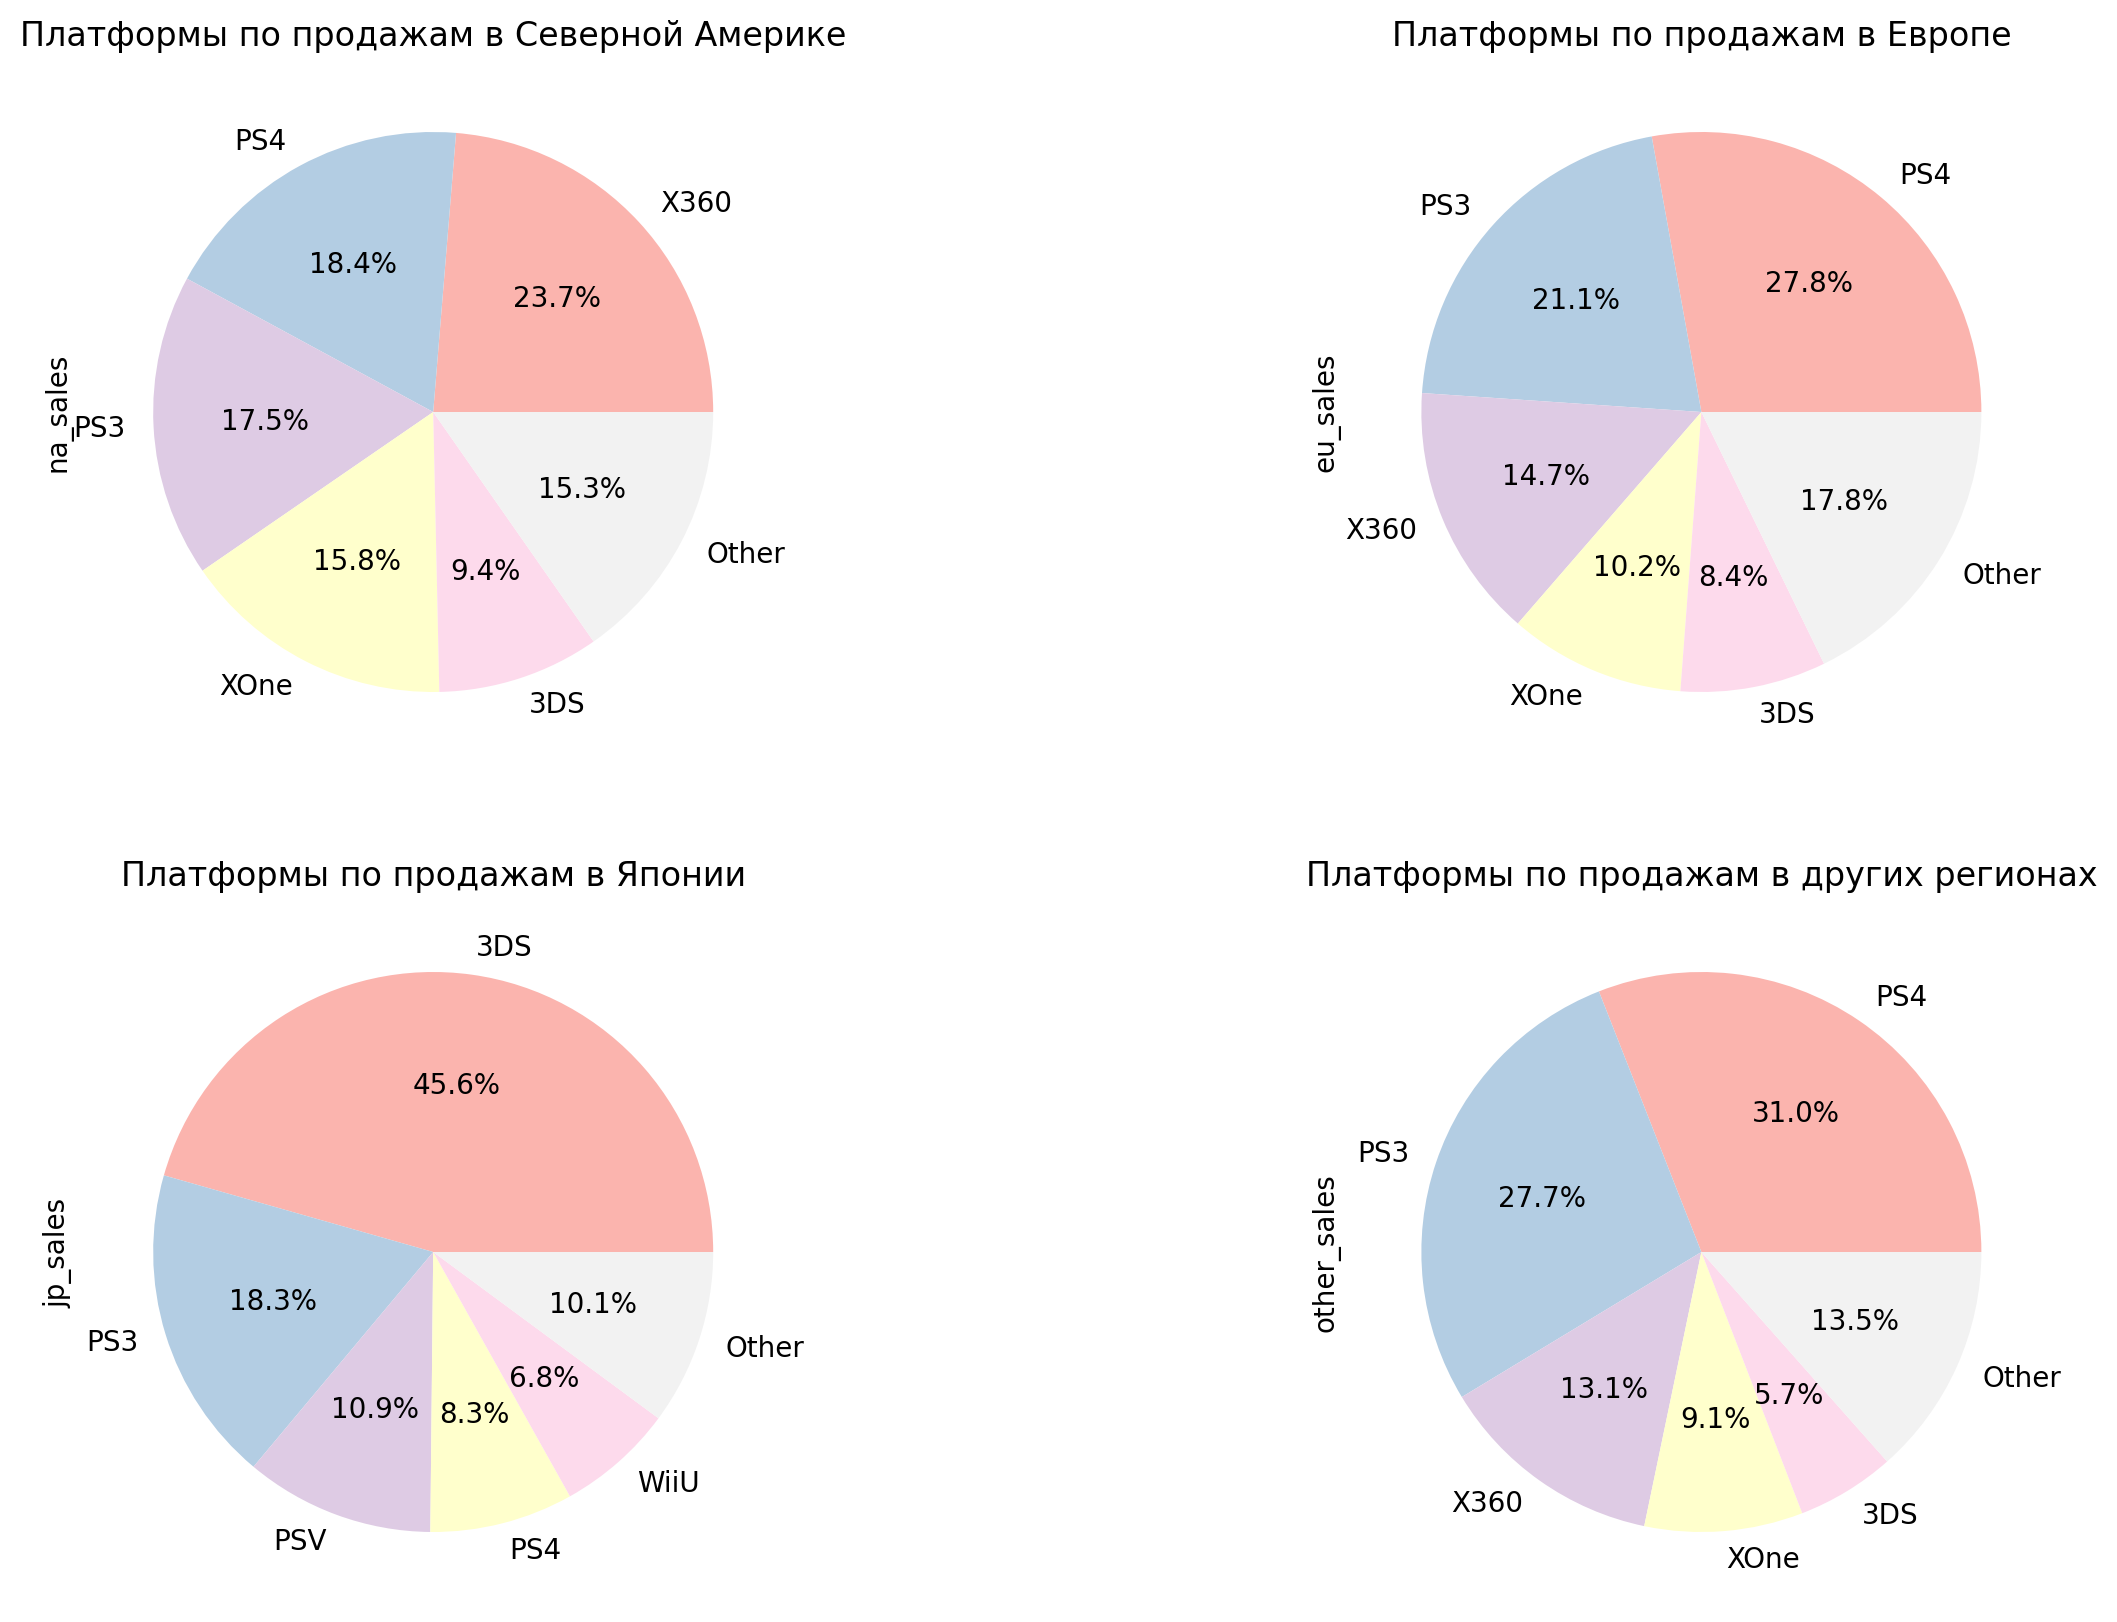

In [60]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

na_sales_plot.plot(kind='pie', autopct='%1.1f%%', cmap='Pastel1', ax=axs[0, 0])
axs[0, 0].set_title('Платформы по продажам в Северной Америке')

eu_data_plot.plot(kind='pie', autopct='%1.1f%%', cmap='Pastel1', ax=axs[0, 1])
axs[0, 1].set_title('Платформы по продажам в Европе')

jp_data_plot.plot(kind='pie', autopct='%1.1f%%', cmap='Pastel1', ax=axs[1, 0])
axs[1, 0].set_title('Платформы по продажам в Японии')

other_data_plot.plot(kind='pie', autopct='%1.1f%%', cmap='Pastel1', ax=axs[1, 1])
axs[1, 1].set_title('Платформы по продажам в других регионах')

plt.show()

**Северная Америка:** самая популярная платформа X360 (24%), следом идут PS4 (18%) и PS3 (17%)  
**Европа:** самая популярная платформа PS4 (~28%), следом идут PS3 (21%) и X360 (15%)  
**Япония:** самая популярная платформа 3DS (45%), следом идут PS3 (18%) и PSV (11%)  
**Другие регионы:** самая популярная платформа PS4 (31%), следом идут PS3 (28%) и X360 (13%)  
  
Топ 3 платформы в Европе и в других регионах идут в одинаковом порядке.  
Топ 3 платформы в Европе и в Северной Америке одинаковые, но идут в разном порядке, в Северной Америке топ-1 это X360, а в Европе ее конкурент PS4.
Япония сильно выбивается из общей картины с платформами 3DS (45%), PS3 (18%) и PSV (11%). Там отдают предпочтение портативным консолям, а в других регионах  - стационарным. 

Проделаем то же самое с жанрами

In [61]:
na_data_genres = actual_data.groupby('genre')['na_sales'].sum().sort_values(ascending=False)
na_genres_plot = na_data_genres.head(5)
na_genres_plot['Other'] = na_data_genres[5:].sum()

eu_data_genres = actual_data.groupby('genre')['eu_sales'].sum().sort_values(ascending=False)
eu_genres_plot = eu_data_genres.head(5)
eu_genres_plot['Other'] = eu_data_genres[5:].sum()

jp_data_genres = actual_data.groupby('genre')['jp_sales'].sum().sort_values(ascending=False)
jp_genres_plot = jp_data_genres.head(5)
jp_genres_plot['Other'] = jp_data_genres[5:].sum()

other_data_genres = actual_data.groupby('genre')['other_sales'].sum().sort_values(ascending=False)
other_genres_plot = other_data_genres.head(5)
other_genres_plot['Other'] = other_data_genres[5:].sum()

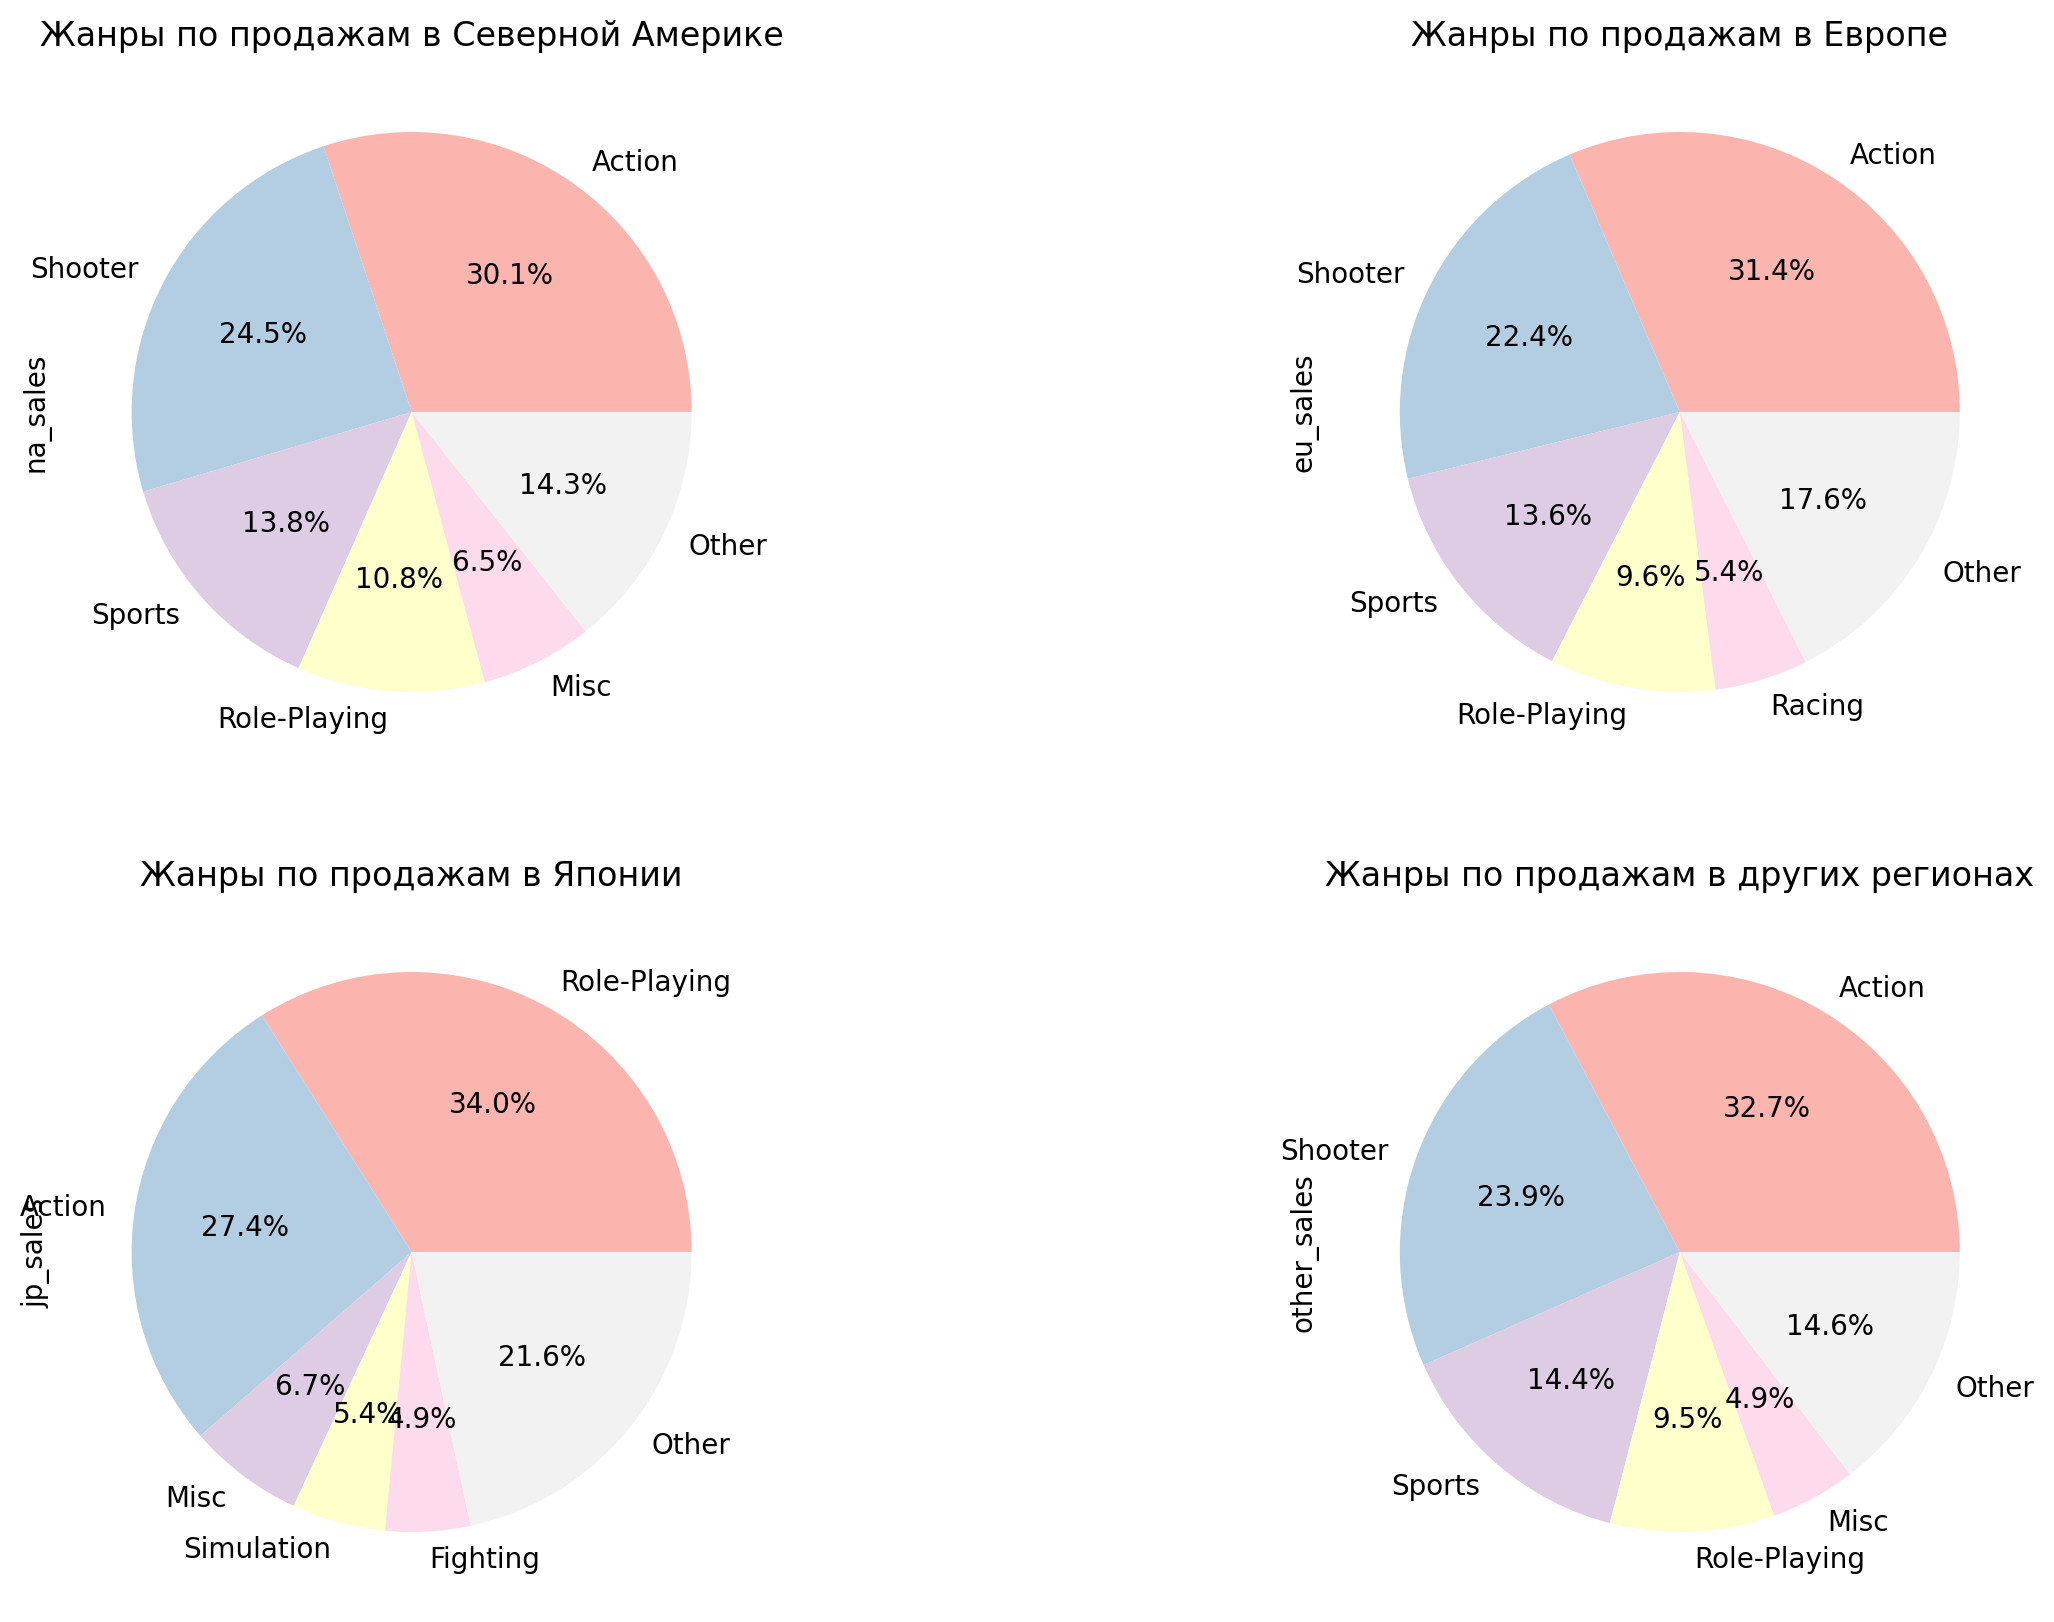

In [62]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

na_genres_plot.plot(kind='pie', autopct='%1.1f%%', cmap='Pastel1', ax=axs[0, 0])
axs[0, 0].set_title('Жанры по продажам в Северной Америке')

eu_genres_plot.plot(kind='pie', autopct='%1.1f%%', cmap='Pastel1', ax=axs[0, 1])
axs[0, 1].set_title('Жанры по продажам в Европе')

jp_genres_plot.plot(kind='pie', autopct='%1.1f%%', cmap='Pastel1', ax=axs[1, 0])
axs[1, 0].set_title('Жанры по продажам в Японии')

other_genres_plot.plot(kind='pie', autopct='%1.1f%%', cmap='Pastel1', ax=axs[1, 1])
axs[1, 1].set_title('Жанры по продажам в других регионах')

plt.show()

Здесь Япония тоже выделяется из общей картины. Во всем остальном мире топ 3 жанра одинаковые и идут в одном и том же порядке: Action, Shooter и Sports. В Японии же самым популярным жанром с большим отрывом становится Role-Playing (34%), после которого идут Action (28%) и Misc (7%)

Теперь посмотрим, влияет ли рейтинг ESRB на продажи в отдельном регионе.

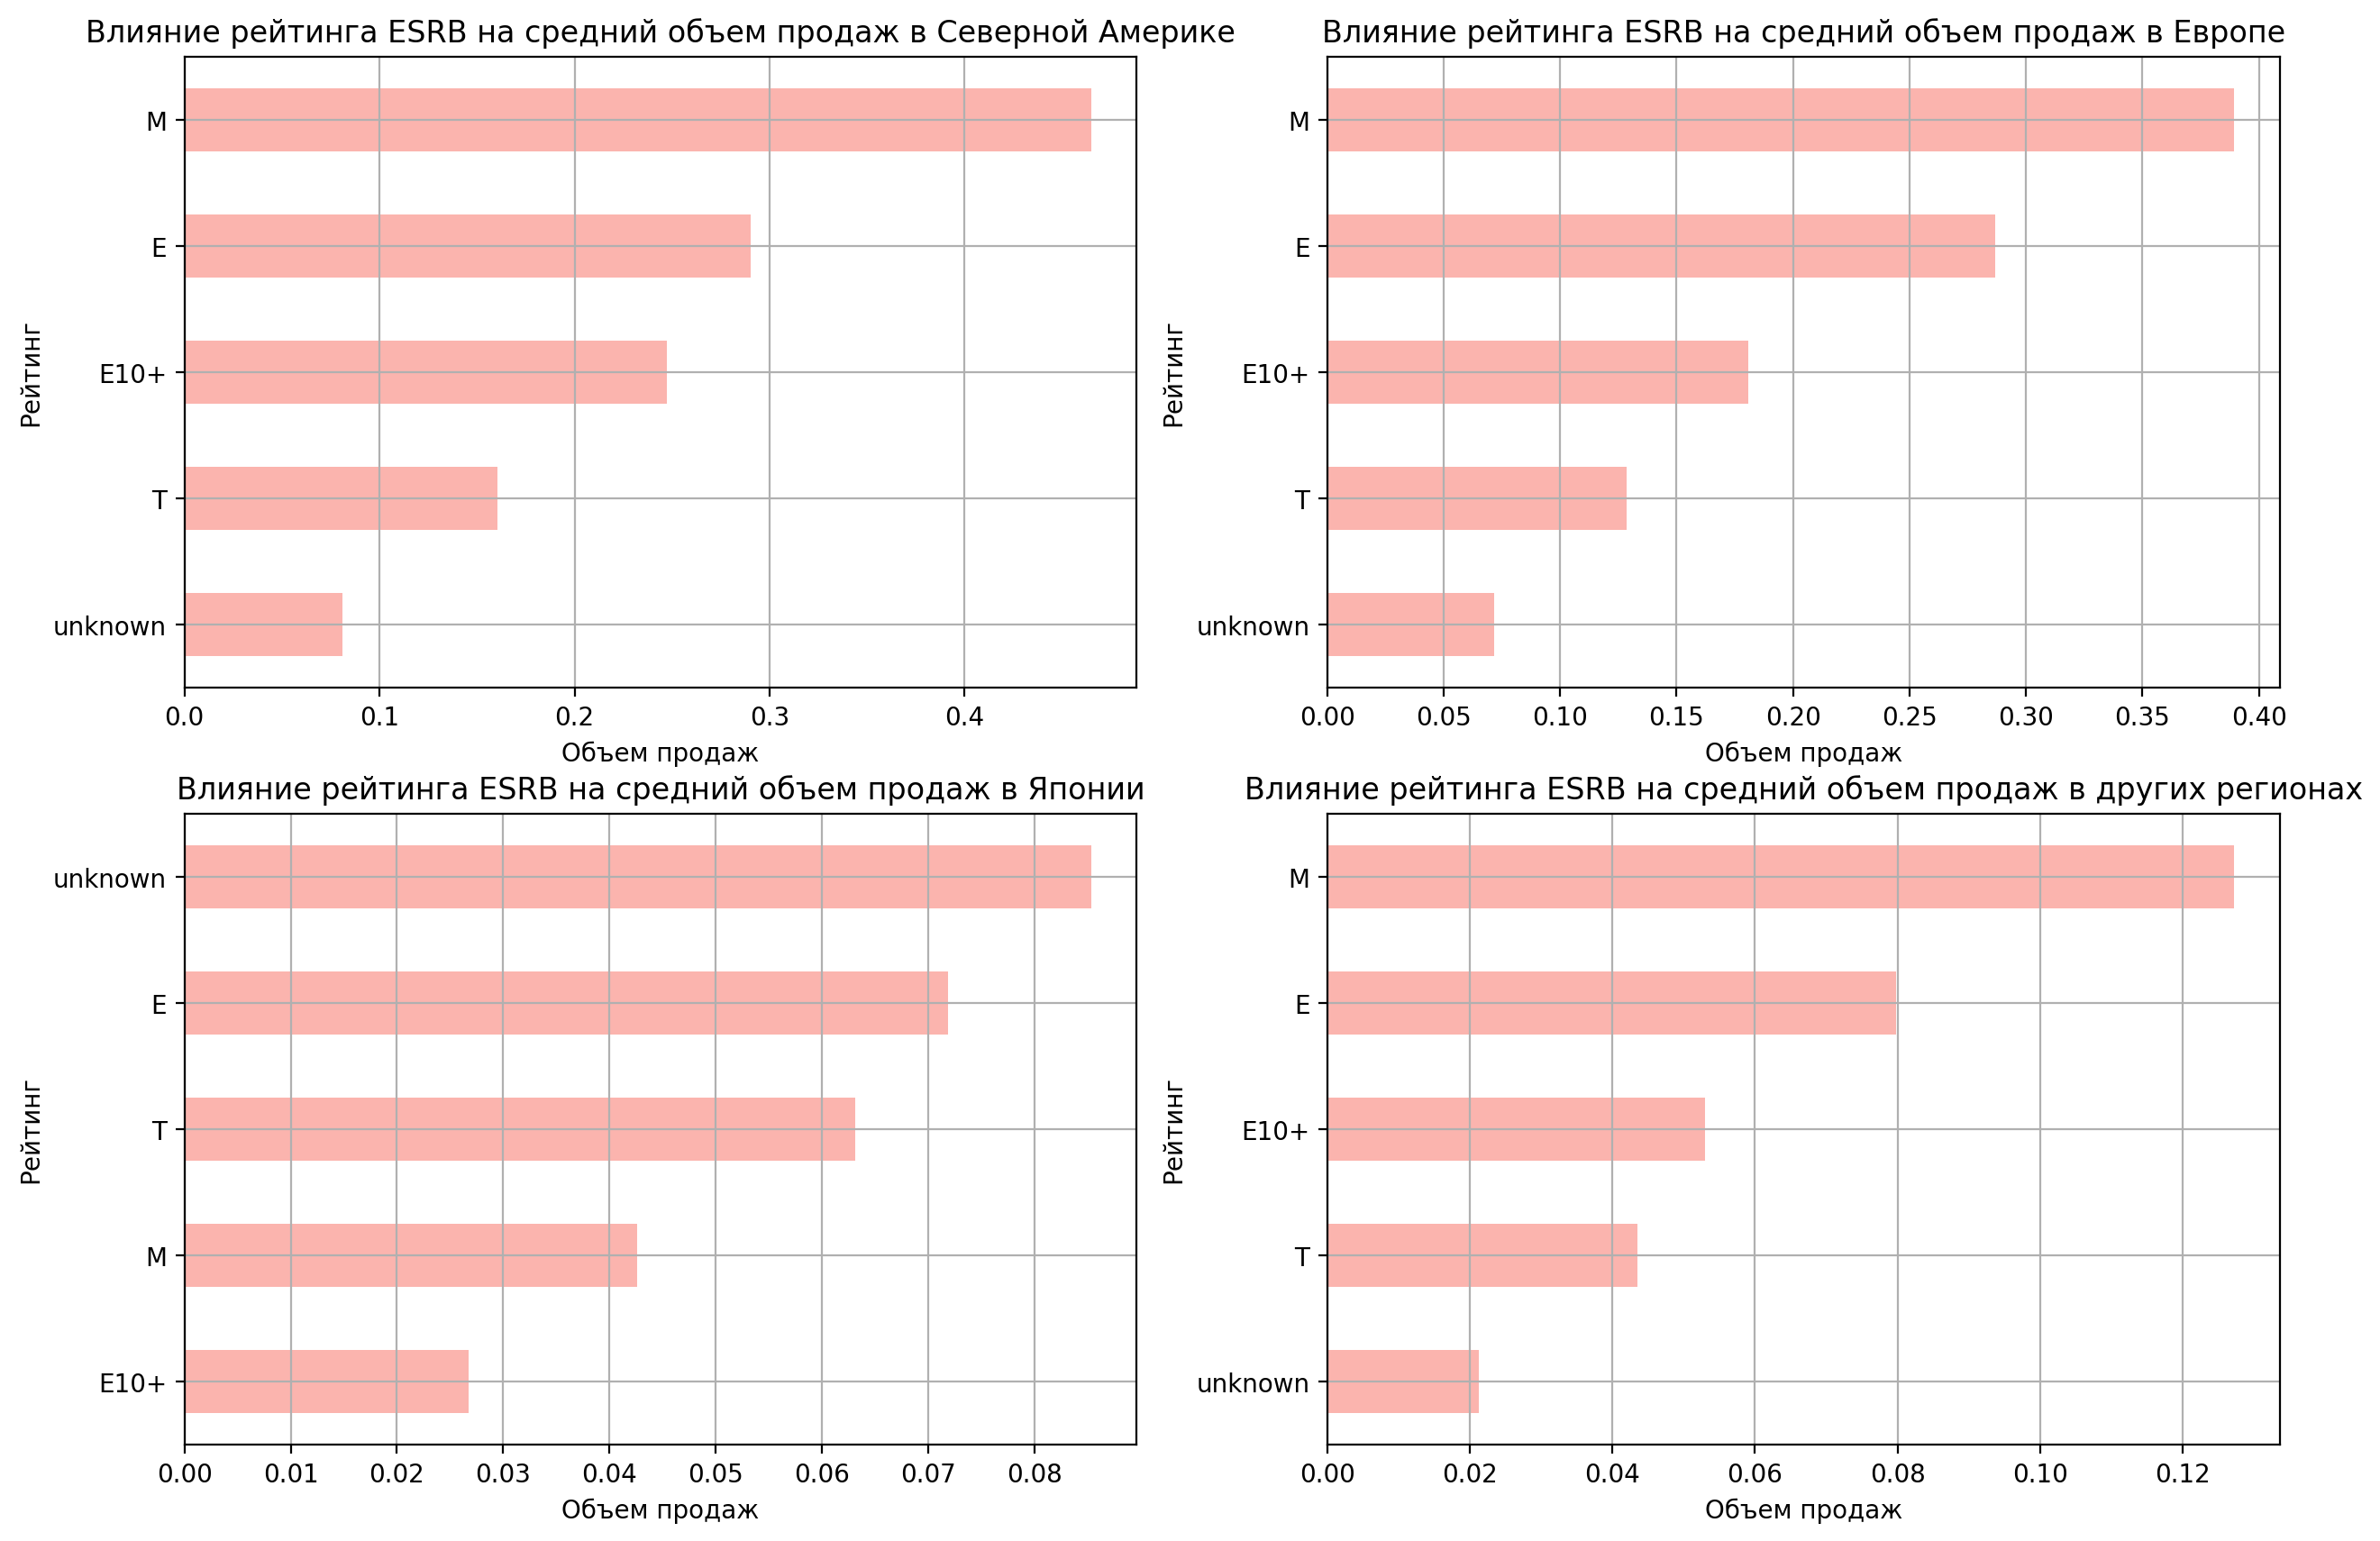

In [63]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

actual_data.groupby('rating')['na_sales'].mean().sort_values(ascending=True).plot(kind='barh', grid=True,
                                                                                 cmap='Pastel1', ax=axs[0, 0])
axs[0, 0].set_xlabel('Объем продаж')
axs[0, 0].set_ylabel('Рейтинг')
axs[0, 0].set_title('Влияние рейтинга ESRB на средний объем продаж в Северной Америке')

actual_data.groupby('rating')['eu_sales'].mean().sort_values(ascending=True).plot(kind='barh', grid=True,
                                                                                 cmap='Pastel1', ax=axs[0, 1])
axs[0, 1].set_xlabel('Объем продаж')
axs[0, 1].set_ylabel('Рейтинг')
axs[0, 1].set_title('Влияние рейтинга ESRB на средний объем продаж в Европе')

actual_data.groupby('rating')['jp_sales'].mean().sort_values(ascending=True).plot(kind='barh', grid=True,
                                                                                 cmap='Pastel1', ax=axs[1, 0])
axs[1, 0].set_xlabel('Объем продаж')
axs[1, 0].set_ylabel('Рейтинг')
axs[1, 0].set_title('Влияние рейтинга ESRB на средний объем продаж в Японии')

actual_data.groupby('rating')['other_sales'].mean().sort_values(ascending=True).plot(kind='barh', grid=True,
                                                                                 cmap='Pastel1', ax=axs[1, 1])
axs[1, 1].set_xlabel('Объем продаж')
axs[1, 1].set_ylabel('Рейтинг')
axs[1, 1].set_title('Влияние рейтинга ESRB на средний объем продаж в других регионах')

plt.show()

M - Mature (18+)  
E - Everyone (0+)  
E10+ (10+)  
T - Teen (13+)  

Во всем мире кроме Японии самыми продаваемыми играми являются игры с рейтингом 18+, следом за ними идут игры 0+, замыкают игры с рейтингом 10-13+.  
В Японии же самый продаваемый рейтинг неизвестен (unknown). Можно предположить, что отсутствие четкой категории рейтинга в Японии может быть обусловлено особенностями рынка и культурными особенностями. Следом в Японии идут игры 0+, затем 13+ и только потом 18+, 10+ замыкает. Возможно, обусловлено особенностями законодательства. 

### Вывод по разделу
1) Почти **40%** всех продаж в **Северной Америке**, около **35%** в **Европе**, в **Японии 13%** как и **в других регионах 11%**  
2) **Топ 3** платформы во всем мире по продажам кроме Японии это **PS4, PS3 и X360**, при этом в **Северной Америке лидирует X360**, а в **остальных частях света** (кроме Японии) **PS4**. В Японии лидируют портативные консоли DS и 3DS.
3) **Топ 3 жанра игр во всем** мире по продажам это **Action, Shooter и Sports (идут в одинаковом порядке).** В Японии самый популярный жанр Role-Playing, затем Action и Misc.
4) **Во всем мире** кроме Японии **самыми продаваемыми** играми являются и**гры с рейтингом 18+,** следом за ними идут **игры 0+,** замыкают игры с **рейтингом 10-13+.**
5) В Японии же самый продаваемый рейтинг неизвестен (unknown). Следом в Японии идут игры 0+, затем 13+ и только потом 18+, 10+ замыкает. Возможно, обусловлено особенностями законодательства и культурными особенностями.


## Проверка гипотез

<img src="https://imgb.ifunny.co/images/e9f25be601dbb9d5f0cb2b04bd596994e76e961a780690057654611a36ef869a_1.jpg" style="width:500px;"/>

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

Гипотеза H0  - средняя пользовательская оценка платформы Xbox One равна средней пользовательской оценке платформы PC на уровне значимости 0.05 
Гипотеза H1 - средняя пользовательская оценка платформы Xbox One не равна средней пользовательской оценке платформы PC на уровне значимости 0.05

Понадобится двусторонняя гипотеза о равенстве средних двух генеральных совокупностей (независимых выборок). Двусторонняя, т.к. гипотеза H1 о неравенстве средних, а не о том, что второе среднее больше/меньше. Выбрал стандартный уровень значимости 0.05.

In [64]:
#отфтльтруем данные, избавимся от нанов
user_data_hypos = actual_data[actual_data['user_score'] != -1]

xone_data = user_data_hypos[user_data_hypos['platform'] == 'XOne']['user_score']
xone_data.count()

182

In [65]:
pc_data = user_data_hypos[user_data_hypos['platform'] == 'PC']['user_score']
pc_data.count()

206

Выборки разного размера => будем использовать параметр equal_var=False 

In [66]:
alpha = 0.05

results = st.ttest_ind(xone_data, pc_data, equal_var=False)

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Можем отвергнуть нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')
    
print('XOne mean:', xone_data.mean(), 'PC mean:', pc_data.mean())

p-value: 0.5489537965134912
Нет оснований отвергнуть нулевую гипотезу
XOne mean: 6.521428571428572 PC mean: 6.4286407766990274


Вывод: на уровне значимости 0.05 не можем отвергнуть нулевую гипотезу о том что cредняя пользовательская оценка платформы Xbox One равна средней пользовательской оценке платформы PC. 

### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

H0 - средняя пользовательская оценка жанра Action равна средней пользовательской оценке жанра Sports на уровне значимости 0.01  
H1 - средняя пользовательская оценка жанра Action не равна средней пользовательской оценке жанра Sports на уровне значимости 0.01

Понадобится двусторонняя гипотеза о равенстве средних двух генеральных совокупностей (независимых выборок). Двусторонняя, т.к. гипотеза H1 о неравенстве средних, а не о том, что второе среднее больше/меньше. Выбрал стандартный уровень значимости 0.05.

In [67]:
action_data = user_data_hypos[user_data_hypos['genre'] == 'Action']['user_score']
action_data.count()

523

In [68]:
sports_data = user_data_hypos[user_data_hypos['genre'] == 'Sports']['user_score']
sports_data.count()

194

Выборки разного размера => будем использовать параметр equal_var=False

In [69]:
#задаем уровень значимости
alpha = 0.05

results = st.ttest_ind(action_data, sports_data, equal_var=False)

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Можем отвергнуть нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')
    
print('Action mean:', action_data.mean(), 'Sports mean:', sports_data.mean())

p-value: 5.989458066467418e-20
Можем отвергнуть нулевую гипотезу
Action mean: 6.825047801147227 Sports mean: 5.455670103092784


Вывод: на уровне значимости 0.05 можем отвергнуть нулевую гипотезу о том что средняя пользовательская оценка жанра Action равна средней пользовательской оценке жанра Sports. Можем предположить, что средняя пользовательская оценка жанра Action не равна средней пользовательской оценке жанра Sports, т.е. что они разные.

### Вывод по разделу:
1) На уровне значимости 0.05 **не можем отвергнуть нулевую гипотезу о том что cредняя пользовательская оценка платформы Xbox One равна средней пользовательской оценке платформы PC.**  
2) На уровне значимости 0.05 можем **отвергнуть нулевую гипотезу** о том что средняя пользовательская оценка жанра Action равна средней пользовательской оценке жанра Sports. **Можем предположить, что средняя пользовательская оценка жанра Action не равна средней пользовательской оценке жанра Sports, т.е. что они разные.**

## Общий вывод

Закономерности, влияющие на успешность игры:  
1) За **последние несколько лет** по продажам **лидируют PS4 и XOne**. Еще есть портативные консоли, но их доля в общем объеме продаж **не так значительна**. Примерно на одном уровне с ними идет **PC**, отдельная категория, которая скорее всего **надолго сохранит свою стабильно небольшую долю рынка.**  
2) **Новейшие платформы,** такие как **PS4, XOne и WiiU** демонстрируют **широкий диапазон продаж с некоторыми очень успешными тайтлами.**  
3) Есть **слабая прямая связь между оценкой критиков и объемом продаж.**  
4) Самые прибыльные жанры - **Shooter, Platform и Sports**  
5) **В первую очередь ставку надо сделать на консоли Playstation и XBox.**  
6) **Самыми продаваемыми** играми являются **игры с рейтингом 18+,** **следом за ними идут 0+,** замыкают игры с рейтингом 10-13+.  
7) **Северная Америка - лидер рынка,** занимающий **40%** от всего объема продаж. Следом идет **Европа с 35%.**  
8) Японский рынок по продажам кардинально отличается от всего остального мира, **Япония - это около 13% от всего объема продаж.**  